In [2]:
##########################################################################################
################  Importing Libraries #######################
import pandas as pd
import numpy as np
## Cell computation timer
#%load_ext autotime
from IPython.display import HTML
## Cell computation timer
%load_ext autotime
from scipy.spatial import distance
import jenkspy
import h5py
from speed_functions1 import * # -- seperate .py file 
import glob
import os

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.36 ms


In [37]:
# || 2. Declare test data locations

H5=[]

Data_Loc = r'C:\Users\Home\Documents\Second Spectrum Everton Project\HDF5 files'

for filename_with_ext in os.listdir(Data_Loc):
    
    if (filename_with_ext.endswith(".h5")):  
        
        # get the file name without the extension
        filename = filename_with_ext.split('.')[0]
        H5.append(filename)

['1059990']

time: 10.9 ms


####  What happens when Southampton Attack? ########

In [35]:

for file in H5:
################  Importing H5 File ####################### 

    filename = r'C:\Users\Home\Documents\Second Spectrum Everton Project\HDF5 files/'+str(file)+'.h5'

    key='result1'
    df=pd.read_hdf(filename,key)
    df.Team_Name=df.Team_Name.fillna('BALL')
    df.name=df.name.fillna('Ball')
    df.columns = df.columns.str.replace(' ', '')
    tracking=df
    tracking['Team_Name']=tracking['Team_Name'].astype(str)
    tracking.Team_Name=tracking.Team_Name.str.strip(' ')

    tracking['team1']=tracking['team'].astype(int)
    tracking.loc[tracking['team'] == '0', 'team'] = '2'
    tracking.loc[tracking['team'] == '0', 'name'] = 'Ball'
    tracking['team']=tracking['team'].astype(int)
    Away=tracking[tracking['team']==-1]
    Away=Away.Team_Name.unique()
    home=tracking[tracking['team']==1]
    home=home.Team_Name.unique()
    tracking['Possession']=np.where(tracking.lastTouch=='home',home,Away)
    tracking['gameClock1']=tracking['gameClock']/60
    tracking.loc[tracking['period'] == 2, 'gameClock1'] = tracking['gameClock1']+45

    ##########################################################################################

    ### Subsetting data for when team: Southampton for animations ###
    SOU_team = 1
    ##########################################################################################
    ##bringing the scale with 108x65 coordinates
    # Players Tracking
    # margin of error after checking with video (x-axis)/ # margin of error after checking with video (y-axis)

    ##########################################################################################
    tracking['x1']=tracking['x']+65
    tracking['y1']=tracking['y']+43

    tracking['x2']=tracking['x']+55
    tracking['y2']=tracking['y']+43

    tracking['x1']=np.where(tracking['x1']<0,0,tracking['x1'])
    tracking['y1']=np.where(tracking['y1']<0,0,tracking['y1'])

    tracking['x2']=np.where(tracking['x2']<0,0,tracking['x2'])
    tracking['y2']=np.where(tracking['y2']<0,0,tracking['y2'])

    tracking=tracking.sort_values(['frameIdx','team'], ascending=[True,False])


    ##########################################################################################
    ############### The below functions add relative distance to ball, goals ################
    ##########################################################################################

    def add_ball_xy(tracking):

        ball_df = tracking[tracking['playerId'] == '00000'].reset_index(drop=True)[['frameIdx', 'x1', 'y1']]
        ball_df.columns = ['frameIdx', 'ball_x1', 'ball_y1']

        tracking = tracking.merge(ball_df, on = "frameIdx")

        return(tracking)

    def add_distance_to_ball(tracking):

        if 'ball_x1' in tracking.columns:
            tracking['distance_to_ball'] = tracking[['x1', 'y1']].sub(np.array( tracking[['ball_x1', 'ball_y1']] )).pow(2).sum(1).pow(0.5)
            tracking.distance_to_ball = tracking.distance_to_ball.round(2)
            return(tracking)

        else:
            print("x||----------------")
            print("Ball x and y coordinates missing - 'add_distance_to_ball' function failed")
            print("Use 'add_ball_xy' to add the missing coordinates")
            print("----------------||x")

    def add_distance_to_goals(tracking, x = 60):

        tracking['distance_to_goal1'] = tracking[['x', 'y']].sub(np.array( [-x, 0] )).pow(2).sum(1).pow(0.5)
        tracking['distance_to_goal2'] = tracking[['x', 'y']].sub(np.array( [x, 0] )).pow(2).sum(1).pow(0.5)

        # trackingdata.distance_to_goal1 = trackingdata.distance_to_goal1.round(2)
        # trackingdata.distance_to_goal2 = trackingdata.distance_to_goal2.round(2)

        return(tracking)

    tracking=add_ball_xy(tracking)
    tracking=add_distance_to_ball(tracking)
    tracking=add_distance_to_goals(tracking)
    tracking = add_speed_classification(tracking)
    tracking.position = tracking.position.fillna('Ball')



    ##########################################################################################
    ###### Defining the ball handler for every frame ###########
    ############################################################################################

    tracking=tracking.sort_values(['frameIdx','distance_to_ball'], ascending=[True,True])
    tracking["rank"] = tracking.groupby("frameIdx")["distance_to_ball"].rank("dense", ascending=True)
    #Subsetting data for the closest player in every frame (Ball Handler)
    tracking=tracking.sort_values(['frameIdx','team'], ascending=[True,True])
    tracking['ball_handler']=np.where((tracking["rank"]==2.0) & (tracking.distance_to_ball<= 2) & (tracking.distance_to_ball> 0),tracking.name,np.nan)
    tracking['ball_handler']=tracking['ball_handler'].fillna(method='ffill')
    tracking['ball_handler1']=np.where((tracking["rank"]==2.0) & (tracking.distance_to_ball<= 1) & (tracking.distance_to_ball> 0),tracking.name,np.nan)
    #tracking['ball_handler1']=np.where(tracking.distance_to_ball== 0, 'Ball',tracking['ball_handler1'])
    tracking['ball_handler1']=tracking['ball_handler1'].fillna('Ball')
    tracking['ball_handler']=np.where(tracking.distance_to_ball== 0, 'Ball',tracking['ball_handler'])
    tracking['ball_handler_team']=np.where((tracking["rank"]==2.0) & (tracking.distance_to_ball<= 2) & (tracking.distance_to_ball> 0),tracking.Team_Name,np.nan)
    tracking['ball_handler_team']=tracking['ball_handler_team'].fillna(method='ffill')
    tracking['ball_handler_team']=np.where(tracking.distance_to_ball== 0, 'Ball',tracking['ball_handler_team'])
    tracking['Team_Name1']=np.where((tracking['Team_Name']!='SOU') & (tracking['Team_Name']!='BALL'),'OPP',tracking['Team_Name'])
    ##########################################################################################

    ## two options ["Alive", "Dead"] - we keep the "Alive" frames only
    alive_tracking = tracking[tracking['live'] == True].reset_index(drop=True)
    Dead_tracking = tracking[tracking['live'] == False].reset_index(drop=True)

    all_alive_frames = list(set(alive_tracking['frameIdx']))

    #Sort out all the dead time to check for set pieces & Frames
    all_dead_times = list(set(Dead_tracking['gameClock1']))
    all_live_times = list(set(alive_tracking['gameClock1']))
    all_dead_frames = list(set(Dead_tracking['frameIdx']))
    all_live_frames = list(set(alive_tracking['frameIdx']))


    ##########################################################################################
    ###### In Possession: Southampton ###########
    ############################################################################################
    # No Ball and Goalkeeper
    NO_BALL_Gk_tracking = alive_tracking[(alive_tracking['position'] != 'Ball') & (tracking['position'] != 'GK')]

    #Southampton Tracking
    Southampton=NO_BALL_Gk_tracking[(NO_BALL_Gk_tracking['Possession'] == 'SOU') & (NO_BALL_Gk_tracking['ball_handler_team']== 'SOU')]

    ##########################################################################################
    ###### When In Possession: Southampton,what is the shape of opposition?   ###########  Sout_Attack1

    Sout_Attack1=Southampton[Southampton['Team_Name1'] == 'OPP']

    #Looking at the direction of the Goal Keeper to identify direction of play

    GK=Sout_Attack1[Sout_Attack1['position']=='GK'][['period','x']]
    GK_mean=GK.groupby(['period']).mean()
    GK_mean['Direction']=np.where(GK_mean['x']<0,-1,1)
    GK_mean['period']=GK_mean.index
    GK_mean1=GK_mean[['period','Direction']].reset_index(drop=True)

    ##### Merging both the datasets to get the direction

    Sout_Attack1=pd.merge(Sout_Attack1,GK_mean1, on='period',how='left')

    #### Sorting the Values for the above datasets

    Sout_Attack1=Sout_Attack1.sort_values(['frameIdx', 'x1'], ascending=[True, False])

    ### Adding Frameid's to a list for both Attack & Defence

    frames_Attack1=list(set(Sout_Attack1['frameIdx']))

    ## Let's take every 9th frame of the all_alive_frames

    frames_Attack1 = frames_Attack1[0::12]

    ##########################################################################################
    ###### When In Possession: Southampton, what is the shape of Southampton?   ###########  Sout_Attack2

    Sout_Attack2=Southampton[Southampton['Team_Name1'] == 'SOU']

    #### Sorting the Values for the above datasets

    Sout_Attack2=Sout_Attack2.sort_values(['frameIdx', 'x1'], ascending=[True, False])

    ### Adding Frameid's to a list for both Attack & Defence

    frames_Attack2=list(set(Sout_Attack2['frameIdx']))

    ## Let's take every 9th frame of the all_alive_frames

    frames_Attack2 = frames_Attack2[0::12]

    ##########################################################################################
    # When the opposition is in Possession? What is the shape of the opposition and Southampton?
    ##########################################################################################

    Opposition=NO_BALL_Gk_tracking[(NO_BALL_Gk_tracking['Possession'] != 'SOU') & (NO_BALL_Gk_tracking['ball_handler_team']!= 'SOU')]

    ############################################################################
    ### Look at the shape of southampton when not in possession ###   Sout_Defense1

    Sout_Defense1=Opposition[Opposition['Team_Name1'] == 'SOU']

    #Looking at the direction of the Goal Keeper to identify direction of play

    GK=Sout_Defense1[Sout_Defense1['position']=='GK'][['period','x']]
    GK_mean=GK.groupby(['period']).mean()
    GK_mean['Direction']=np.where(GK_mean['x']<0,-1,1)
    GK_mean['period']=GK_mean.index
    GK_mean1=GK_mean[['period','Direction']].reset_index(drop=True)

    ##### Merging both the datasets to get the direction

    Sout_Defense1=pd.merge(Sout_Defense1,GK_mean1, on='period',how='left')

    #### Sorting the Values for the above datasets

    Sout_Defense1=Sout_Defense1.sort_values(['frameIdx', 'x1'], ascending=[True, False])

    #### Adding Frameid's to a list for both Attack & Defence

    frames_Defense1=list(set(Sout_Defense1['frameIdx']))

    #### Let's take every 9th frame of the all_alive_frames

    frames_Defense1 = frames_Defense1[0::12]

    ############################################################################
    ### Look at the shape of opposition when southampton not in possession ###   Sout_Defense2

    Sout_Defense2=Opposition[Opposition['Team_Name1'] == 'OPP']

    #### Sorting the Values for the above datasets
    Sout_Defense2=Sout_Defense2.sort_values(['frameIdx', 'x1'], ascending=[True, False])

    ### Adding Frameid's to a list for both Attack & Defence
    frames_Defense2=list(set(Sout_Defense2['frameIdx']))

    ## Let's take every 9th frame of the all_alive_frames
    frames_Defense2 = frames_Defense2[0::12]


    #Looking at the direction of the Goal Keeper to identify direction of play: Opposition

    GK=Sout_Attack1[Sout_Attack1['position']=='GK'][['period','x']]
    GK_mean=GK.groupby(['period']).mean()
    GK_mean['Direction']=np.where(GK_mean['x']<0,-1,1)
    GK_mean['period']=GK_mean.index
    GK_mean1=GK_mean[['period','Direction']].reset_index(drop=True)
    GK_mean1['Team_Name'] =  'OPP'
    #Looking at the direction of the Goal Keeper to identify direction of play: Southampton

    GK=Sout_Attack2[Sout_Attack2['position']=='GK'][['period','x']]
    GK_mean=GK.groupby(['period']).mean()
    GK_mean['Direction']=np.where(GK_mean['x']<0,-1,1)
    GK_mean['period']=GK_mean.index
    GK_mean2=GK_mean[['period','Direction']].reset_index(drop=True)
    GK_mean2['Team_Name'] =  'SOU'
    GK_mean3=GK_mean1.append(GK_mean2,ignore_index=True)

    ##### Merging both the datasets to get the direction

    tracking=pd.merge(tracking,GK_mean3, on=['period','Team_Name'],how='left')

    ##### Sorting the tracking dataset values

    tracking=tracking.sort_values(['frameIdx', 'Team_Name'], ascending=[True, False])
    tracking.Direction=tracking.Direction.fillna(method='ffill')
    #tracking.Direction=tracking.Direction.astype(int)


    #Assigning Proxy associated to x-axis (three Vertical zones)
    ##### x-zone #####

    bins = [0,40,80,121]
    labels = ["Defensive-Third","Middle-Third","Offensive-Third"]
    labels1 = ["Offensive-Third","Middle-Third","Defensive-Third"]
    tracking['x_zone']= np.where(tracking.Direction==-1,pd.cut(tracking['ball_x1'], bins=bins, labels=labels),pd.cut(tracking['ball_x1'], bins=bins, labels=labels1))
    tracking['next_x_zone']=tracking['x_zone'].shift(-1)

    ##### y-zone #####
    bins1 = [0,12,24,55,68,80]
    labels2 = ["Right","Right-Half-Space","Middle","Left-Half-Space","Left"]
    labels3 = ["Left","Left-Half-Space","Middle","Right","Right-Half-Space"]
    tracking['y_zone']= np.where(tracking.Direction==-1,pd.cut(tracking['ball_y1'], bins=bins1, labels=labels2),pd.cut(tracking['ball_y1'], bins=bins1, labels=labels3))
    tracking['next_y_zone']=tracking['y_zone'].shift(-1)

    ###########################   checking for set pieces   ##################################

    tracking['count'] = np.where(tracking['live']!= tracking['live'].shift(-1),1,0)
    #checking where count
    check2=tracking[(tracking['count']==1) & (tracking['live']==False)][['frameIdx']].reset_index(drop=True)
    check3=check2[1:]
    check3['frameId_end']=check3['frameIdx']+200
    check3['id']=check3.index

    zipped = zip(check3['id'],check3['frameIdx'], check3['frameId_end'])

    df = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                       columns=['id','number'])
    set_piece_frames=df['number'].to_list()

    '''We want to join qualifying low block frames into 'low-'block' sequences, if the next qualifying frame is less than 2 seconds away it is added to the current low-block sequence. A low-block sequence directory can be created with the start and end frames of each distinct low-block sequence. '''


    ######################## Low/Mid Block Against Opposition ###########################

    centroid_x = [] # a list to append all the results to
    centroid_y = [] # a list to append all the results to


    for F in frames_Attack1:

        def_seg = Sout_Attack1[Sout_Attack1['frameIdx'] == F].reset_index(drop=True)

        centroid_x.append(def_seg.x.mean())
        centroid_y.append(def_seg.y.mean())

    #Low Block Check: +ve Direction
    centroid_min = 15
    centroid_max = 40

    low_blocks_frameID_centroids1 = []

    for i in range(len(centroid_x)):
        if centroid_x[i] >= centroid_min:
            if centroid_x[i] <= centroid_max:
                low_blocks_frameID_centroids1.append(frames_Attack1[i])

    #Low Block Check: -ve Direction
    centroid_min = -40
    centroid_max = -15

    low_blocks_frameID_centroids2 = []

    for i in range(len(centroid_x)):
        if centroid_x[i] >= centroid_min:
            if centroid_x[i] <= centroid_max:
                low_blocks_frameID_centroids2.append(frames_Attack1[i])
    low_blocks_frameID_centroids=list((set(low_blocks_frameID_centroids1 + low_blocks_frameID_centroids2)))

    ## Removing the set piece frames 

    low_blocks_frameID_centroids = [i for i in low_blocks_frameID_centroids if i not in set_piece_frames] 
    low_blocks_frameID_centroids.sort(reverse=False)

    #### Subsetting Low-Block scenarios

    gap_threshold = 100 # under 100 frames = 4 seconds 
    duration_threshold = 200 # keep sequences with a length above 200 = (8 seconds)
    lb_sequence_id = 0

    lb_sequence_id_list = [0]

    for lb_frame in range(1,len(low_blocks_frameID_centroids)):

            if (low_blocks_frameID_centroids[lb_frame] - low_blocks_frameID_centroids[lb_frame-1]) <= gap_threshold:

                lb_sequence_id_list.append(lb_sequence_id)

            else:
                lb_sequence_id = lb_sequence_id + 1
                lb_sequence_id_list.append(lb_sequence_id)


    lb_sequence_info = pd.DataFrame(
        {'frameIdx': low_blocks_frameID_centroids,
         'lb_sequence_id': lb_sequence_id_list
        })


    start_of_seq = []
    end_of_seq = [] 

    unique_sequenceids = list(set(lb_sequence_id_list))

    for uID in unique_sequenceids:

        temp = lb_sequence_info[lb_sequence_info['lb_sequence_id'] == uID]

        start_of_seq.append(min(temp.frameIdx))
        end_of_seq.append(max(temp.frameIdx))

    lb_sequence_summary = pd.DataFrame(
        {'frameID_start': start_of_seq,
         'frameID_end': end_of_seq,
         'lb_sequence_id': unique_sequenceids
        })

    ## add a duration to thee sequence 
    #lb_sequence_summary['frameID_start']=lb_sequence_summary['frameID_end']-100

    #lb_sequence_summary['frameID_end']=lb_sequence_summary['frameID_end']+100

    lb_sequence_summary['duration'] = lb_sequence_summary['frameID_end'] - lb_sequence_summary['frameID_start']

    lb_sequence_summary = lb_sequence_summary[lb_sequence_summary['duration'] >= duration_threshold].reset_index(drop=True)
    #lb_sequence_summary

    ###Check for the times of the above frames

    zipped = zip(lb_sequence_summary['lb_sequence_id'],lb_sequence_summary['frameID_start'], lb_sequence_summary['frameID_end'])

    df = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                       columns=['lb_sequence_id','number'])
    lb_sequence_summary_frames=df['number'].to_list()
    lb_sequence_summary_frames.sort(reverse=False)
    lb_sequence_summary_frames=lb_sequence_summary_frames[0::9]

    ###############################################################

    ### Implementing clusters to cluster defense of opposition
    b=[]
    a=[]
    e=[]
    f=[]
    g=[]
    k=[]
    l=[]
    z=[]

    for frame_select in lb_sequence_summary_frames:

        track_seg = tracking[tracking.frameIdx == frame_select]
        track_seg1=track_seg[(track_seg['Team_Name1'] == 'OPP') & (track_seg['position'] != 'GK')].reset_index()

        breaks = jenkspy.jenks_breaks(track_seg1['x1'], nb_class=3)

        #################################################
        track_seg = tracking[tracking.frameIdx == frame_select]
        ball=track_seg[track_seg['Team_Name'] == 'BALL']
        ball_handler=track_seg['ball_handler'].unique()
        ball_handler=ball_handler[:1]
        ball_handler_x=track_seg['x1'].unique()
        ball_handler_x=ball_handler_x[:1]
        x_zone=ball['x_zone'].unique()
        #x_zone=x_zone[:1]
        y_zone=ball['y_zone'].unique()
        #y_zone=y_zone[:1]
        ball_handler_team=track_seg['ball_handler_team'].unique()
        ball_handler_team=ball_handler_team[:1]
        ##########################################

        f.append(ball_handler)
        e.append(frame_select)
        g.append(ball_handler_x)
        b.append(breaks)
        l.append(x_zone)
        z.append(y_zone)
        a.append(frame_select)
        k.append(ball_handler_team)


    b1=pd.DataFrame(b).reset_index(drop=True)
    a1=pd.DataFrame(a).reset_index(drop=True)
    c=pd.merge(a1, b1, left_index=True, right_index=True)
    c1=c.set_axis(['frameIdx','First_Line','Second_Line','Third_Line','Fourth_Line'], axis=1, inplace=False)
    c2=pd.merge(c1,Sout_Defense1[['frameIdx','Direction']], on='frameIdx',how='left').drop_duplicates(keep='last').fillna(method='ffill')

    #########################################################

    f1=pd.DataFrame(f).reset_index(drop=True)
    e1=pd.DataFrame(e).reset_index(drop=True)
    g1=pd.DataFrame(g).reset_index(drop=True)
    k1=pd.DataFrame(k).reset_index(drop=True)
    l1=pd.DataFrame(l).reset_index(drop=True)
    z1=pd.DataFrame(z).reset_index(drop=True)
    #z1=z1.T
    #l1=l1.T
    ef1=pd.merge(e1, f1, left_index=True, right_index=True)
    efg1=pd.merge(ef1, g1, left_index=True, right_index=True)
    efgk1=pd.merge(efg1, k1, left_index=True, right_index=True)
    efgkl1=pd.merge(efgk1, l1, left_index=True, right_index=True)
    efgklz1=pd.merge(efgkl1, z1, left_index=True, right_index=True)
    efgklz1=efgklz1.set_axis(['frameIdx','Ball_Handler','Ball_Handler_x1','ball_handler_team','x_zone','y_zone'], axis=1, inplace=False)

    #########################################################
    c2_efgdf1=pd.merge(c2,efgklz1, on='frameIdx',how='left').drop_duplicates(keep='first')

    #########################################################
    ############ Ball receptions between lines ##############

    c2_efgdf1['Ball_receptions']=np.where((c2_efgdf1.Direction==1) & (c2_efgdf1.Ball_Handler_x1>= c2_efgdf1.Third_Line) & (c2_efgdf1.Ball_Handler_x1<= c2_efgdf1.Fourth_Line) & (c2_efgdf1.ball_handler_team=='SOU'),c2_efgdf1.Ball_Handler,np.nan)
    c2_efgdf1['Ball_receptions']=np.where((c2_efgdf1.Direction==-1) & (c2_efgdf1.Ball_Handler_x1>= c2_efgdf1.Third_Line) & (c2_efgdf1.Ball_Handler_x1<= c2_efgdf1.Fourth_Line) & (c2_efgdf1.ball_handler_team=='SOU'),c2_efgdf1.Ball_Handler,c2_efgdf1['Ball_receptions'])
    Ball_receptions=c2_efgdf1.loc[c2_efgdf1['Ball_receptions'] != c2_efgdf1['Ball_receptions'].shift(1)]
    Ball_receptions=Ball_receptions.dropna(subset=['Ball_receptions'])
    Ball_receptions1=pd.merge(Ball_receptions,df, left_on='frameIdx', right_on='number', how='left')


    #### Ball Receptions in the offensive zone
    Ball_receptions2=Ball_receptions1[Ball_receptions1['x_zone']=='Offensive-Third']
    #Ball_receptions_Off=Ball_receptions2[['frameIdx','Ball_receptions','x_zone','y_zone']]
    Ball_receptions_Off=Ball_receptions2
    Ball_receptions_Off['match_id']=str(file)
    Ball_receptions_Off.to_csv(r'C:\Users\Home\Documents\Second Spectrum Everton Project\Results\Ball Receptions between Lines/'+str(file)+'.csv')
    
    ####################### Overloads  ######################################

    from scipy.spatial import KDTree
    from collections import Counter

    a=[]
    b=[]
    c=[]
    d=[]
    e=[]
    f=[]
    g=[]
    h=[]

    for frame_select in lb_sequence_summary_frames:

        track_seg2 = tracking[tracking.frameIdx == frame_select]
        #Gameclock=track_seg2[['gameClock1']]
        track_seg3=track_seg2[(track_seg2['rank']<8) & (track_seg2['distance_to_ball']<20)]
        team=track_seg3[~(track_seg3['Team_Name1']=='BALL')]
        teamx=track_seg3[track_seg3['Team_Name1']=='SOU']
        SOU_name=teamx[['name']].T
        SOU_name=SOU_name.values
        SOU_zones=teamx[['y_zone']].T
        SOU_zones=SOU_zones.values
        team3=track_seg3[(track_seg3['Team_Name1']=='BALL')]
        y_zone=team3[['y_zone']].T
        y_zone=y_zone.values
        rank=teamx[['rank']].T
        rank=rank.values
        ball_handlerx=teamx[['ball_handler']].T
        ball_handlerx=ball_handlerx.values
        number=teamx[['number']].T
        number1=number.values
        number1=number1.astype(int)
        value_counts=Counter(team.Team_Name1)

        a.append(number1)
        b.append(frame_select)
        c.append(rank)
        d.append(value_counts)
        e.append(y_zone)
        f.append(SOU_name)
        g.append(ball_handlerx)
        h.append(SOU_zones)

    Closest_points = pd.DataFrame(
            {'frameID': b,
             'number1': a,
             'rank': c,
             'value_counts': d,
             'y_zone': e,
             'Sou_Players':f,
             'Ball_Handler':g,
             'SOU_zones':h
            })

    Closest_points=pd.merge(Closest_points,df, left_on='frameID', right_on='number', how='left')
    overloads=pd.DataFrame(Closest_points['value_counts'].values.tolist())
    Closest_points=pd.merge(Closest_points,overloads, left_index=True, right_index=True, how='left')
    #Closest_points1['Opposition']
    Closest_points1=Closest_points.loc[(Closest_points['SOU']-Closest_points['OPP'] <=1) & (Closest_points['SOU']-Closest_points['OPP'] >=0)]
    Closest_points2=Closest_points1[Closest_points1['SOU']>2]

    #Closest_points_CHECK1=Closest_points_CHECK[Closest_points_CHECK['lb_sequence_id']==11]

    Closest_points2['OPP']=Closest_points2['OPP'].astype(int)
    Closest_points2['SOU']=Closest_points2['SOU'].astype(int)

    #Closest_points2['Overload']=str(Closest_points2['SOU'])+'v'+str(Closest_points2['OPP'])
    cols=['SOU','OPP']
    Closest_points2['Overload'] = Closest_points2[cols].apply(lambda row: 'v'.join(row.values.astype(str)), axis=1)
    #Closest_points3=Closest_points2[['y_zone','Overload','lb_sequence_id']]
    Closest_points3=Closest_points2.loc[Closest_points2['y_zone'] != Closest_points2['y_zone'].shift(1)]
    Closest_points3['match_id']=str(file)
    Closest_points3.to_csv(r'C:\Users\Home\Documents\Second Spectrum Everton Project\Results\Overloads/'+str(file)+'.csv')

  ################# Runs for Southampton #################


    printer = True
    all_run_sequence_summary = pd.DataFrame()

    for j in list(range(len(lb_sequence_summary))):

        #RR = 19
        ## select the low block sequence 
        lg_seg_idx = j
    #     print(RR)
        lb_select = lb_sequence_summary.iloc[lg_seg_idx]

    #     print(lb_select.lb_sequence_id)

    #     print("/")

        ## create a segment of tracking segment
        lb_seg = tracking[(tracking['frameIdx'].between(lb_select.frameID_start,lb_select.frameID_end + 75)) & (tracking['live'] == True)].reset_index(drop=True)

        ## find defensive line 
        last_line=['LCB','RCB','LB','DF','SUB']
        oppo_seg = lb_seg[(lb_seg['Team_Name'] != 'SOU') & (lb_seg['position'].isin(last_line))]

        ## get attacking direction of defensive team 
        att_dir = oppo_seg.iloc[0]['Direction']

        ## calculate the defensive line
        frame_list = []
        def_line_list = []

        ## loop through and get the defensive line for each frame
        for fr in list(set(oppo_seg.frameIdx)):

            frame_list.append(fr) # append the frame 
            temp_seg = oppo_seg[oppo_seg['frameIdx'] == fr].reset_index(drop=True)
            #defensive_seg=temp_seg[temp_seg['position'].isin(last_line)].reset_index(drop=True)

            if att_dir == -1:
                temp_seg = temp_seg.sort_values(by=['frameIdx', 'x1'], ascending=[True, True]).reset_index(drop=True)
            else: 
                temp_seg = temp_seg.sort_values(by=['frameIdx', 'x1'], ascending=[True,False]).reset_index(drop=True)

            def_line_list.append(temp_seg.iloc[0:2]['x1'].mean()) # append the defensive last line


        ## create a summary dataframe 
        the_view = pd.DataFrame({'frameIdx': frame_list,'def_line': def_line_list})

        lb_seg['Direction'] = att_dir # add attacking direction used 
        lb_seg = pd.merge(lb_seg, the_view, on="frameIdx",how='left') # merge together so the defensive line appears as a new column
        ## find defensive line 
        fcn_seg = lb_seg[lb_seg['Team_Name1'] == 'SOU'].reset_index(drop=True)

    #     if printer:
    #         print(fcn_seg.head())    
    #         printer = False
    #     print("list(set(fcn_seg['player_id']))", len(list(set(fcn_seg['player_id']))))

        for player in list(set(fcn_seg['name'])):

    #         print(player, "in", lb_select.lb_sequence_id)

            player_seg = fcn_seg[fcn_seg['name'] == player].reset_index(drop=True)
            player_seg['next_x1'] = player_seg['x1'].shift(-1)
            player_seg['next_speed'] = player_seg['speed'].shift(-1)
    #         print("player_seg.iloc[0]['attacking_direction']", player_seg.iloc[0]['attacking_direction'])
            if player_seg.iloc[0]['Direction'] == -1:
                player_seg['direction']=np.where((player_seg['x1'] < player_seg['next_x1']),1,0)
                player_seg['close_to_def_line']=np.where( ( abs(player_seg['def_line'] - player_seg['x1']) <= 8),1,0)
                player_seg['in_front_of_line']=np.where( (player_seg['def_line'] > player_seg['x1']),1,0)
                player_seg['run_broken_line']=np.where((player_seg['def_line']< player_seg['x1']),1,0)
                player_seg['on_ball']=np.where((player_seg['distance_to_ball']<= 0.8),1,0)
    #             player_seg['vertical_gain_5']=np.where( ((player_seg['next_x'] - player_seg['x']) > 5) ,1,0)
                player_seg['vertical_gain']=np.where( ((player_seg['next_speed'] - player_seg['speed']) > 0.1) ,1,0)


            elif player_seg.iloc[0]['Direction'] == 1:
                player_seg['direction']=np.where((player_seg['x1'] > player_seg['next_x1']),1,0)
                player_seg['close_to_def_line']=np.where( (abs(player_seg['def_line'] - player_seg['x1']) >= -8),1,0)
                player_seg['in_front_of_line']=np.where( (player_seg['def_line'] < player_seg['x1']),1,0)
                player_seg['run_broken_line']=np.where((player_seg['def_line']>player_seg['x1']),1,0)
                player_seg['on_ball']=np.where((player_seg['distance_to_ball']<= 0.8),1,0)
    #             player_seg['vertical_gain_5']=np.where( ((player_seg['next_x'] - player_seg['x']) < -5) ,1,0)
                player_seg['vertical_gain']=np.where( ((player_seg['next_speed'] - player_seg['speed']) > 0.1) ,1,0)


            speeds = ['jogging','low_speed_running' , 'high_speed_running','high_speed_sprinting', 'low_speed_sprinting']    
            player_seg['run_speed'] =  np.where((player_seg['speed_class'].isin(speeds)),1,0)
    #         player_seg['forward_run_5'] = np.where((  (player_seg['Direction'] == 1)  & (player_seg['vertical_gain_5'] == 1) & (player_seg['dist_to_def_line']  == 1) & (player_seg['run_speed'] == 1) ), 1, 0)
            player_seg['forward_run'] = np.where((  (player_seg['direction'] == 1)  & (player_seg['close_to_def_line'] == 1) & (player_seg['vertical_gain'] == 1) & (player_seg['in_front_of_line']  == 1) & (player_seg['run_speed'] == 1) ), 1, 0)

    #         if printer:
    #             print("'frameID', 'x', 'y', 'vertical_gain', 'on_ball', 'forward_run'")
    #             print(player_seg[['frameID', 'x', 'vertical_gain',  'forward_run', 'in_front_of_line', 'close_to_def_line', 'def_line']])    
    #             printer = False
    #         if lb_select.lb_sequence_id == 17:

            print_boi = True

            if len(list(set(player_seg.forward_run))) > 1:
    #             print("*"*80)

                ## bridge gaps in runs of 12 frames 
                run_happening = []
                for ii in list(range(0, len(player_seg) - 12)):
                    run_happening.append( int( (1 in list(set(player_seg.iloc[ii:ii+12].forward_run))) == True) )
                player_seg['forward_run2'] = run_happening + list(player_seg.iloc[len(player_seg)-12:len(player_seg)].forward_run)



                runs_frameIDs = list(player_seg[player_seg['forward_run2'] == 1].frameIdx)

                gap_threshold = 12 # under 100 frames = 4 seconds 
                run_sequence_id = 1

                run_sequence_id_list = [1]

                for run_frame in range(1,len(runs_frameIDs)):

                        if (runs_frameIDs[run_frame] - runs_frameIDs[run_frame-1]) <= gap_threshold:

                            run_sequence_id_list.append(run_sequence_id)

                        else:
                            run_sequence_id = run_sequence_id + 1
                            run_sequence_id_list.append(run_sequence_id)
                run_sequence_info = pd.DataFrame(
                    {'frameIdx': runs_frameIDs,
                     'run_sequence_id': run_sequence_id_list
                    })


                start__ = []
                end__ = []
                past_line__ = []
                break_line__ = []
                player_id__ = []
                run_id__ = []
                y__start = []
                y__end = []

                for s in list(set(run_sequence_info.run_sequence_id)):

                    start_frame = run_sequence_info[run_sequence_info['run_sequence_id'] == s].frameIdx.min()
                    end_frame = run_sequence_info[run_sequence_info['run_sequence_id'] == s].frameIdx.max()

                    start__.append(start_frame)
                    end__.append(end_frame)

                    run_seg_start = player_seg[player_seg['frameIdx']==start_frame]
                    run_seg_end = player_seg[player_seg['frameIdx']==end_frame+50]
                    y__start.append(run_seg_start.y_zone.unique())
                    y__end.append(run_seg_end.y_zone.unique())

                    player_id__.append(player)
                    run_id__.append(s)


                run_sequence_summary = pd.DataFrame(
                    {'start': start__,
                     'end': end__,
                     'player_name' : player_id__,
                     'run_id' :run_id__,
                     'zone_start':y__start,
                     'zone_end':y__end
                    })


                in_behind_scope = 5
                on_ball_scope = 100 


                in_behind__ = []
                on_ball__ = [] 

                for r in list(range(len(run_sequence_summary))):

                    run_info = run_sequence_summary.iloc[r]
                    in_behind__.append(1 in set(player_seg[player_seg['frameIdx'].between(run_info.start, run_info.end + in_behind_scope)].run_broken_line))
                    on_ball__.append(1 in set(player_seg[player_seg['frameIdx'].between(run_info.start, run_info.end + on_ball_scope)].on_ball))   

                run_sequence_summary['in_behind'] = in_behind__
                run_sequence_summary['on_ball'] = on_ball__            
                run_sequence_summary['lb_sequence_id'] = lb_select.lb_sequence_id

                all_run_sequence_summary = all_run_sequence_summary.append(run_sequence_summary)

    all_run_sequence_summary['match_id']=str(file)
    all_run_sequence_summary['strategy_id'] = ["r_" + str(a) + "_" + str(b) for a,b in zip(all_run_sequence_summary['lb_sequence_id'] , all_run_sequence_summary['run_id'])]
    all_run_sequence_summary['strategy_type'] = "run"
    all_run_sequence_summary = all_run_sequence_summary.reset_index(drop=True)

    del all_run_sequence_summary['run_id']

    all_run_sequence_summary.to_csv(r'C:\Users\Home\Documents\Second Spectrum Everton Project\Results\Runs/'+str(file)+'.csv')


C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:485: SettingWithCopyWarning: 
A value i

time: 16min 16s


####  What happens when Southampton Defend? ########

In [38]:

for file in H5:
################  Importing H5 File ####################### 

    filename = r'C:\Users\Home\Documents\Second Spectrum Everton Project\HDF5 files/'+str(file)+'.h5'

    key='result1'
    df=pd.read_hdf(filename,key)
    df.Team_Name=df.Team_Name.fillna('BALL')
    df.name=df.name.fillna('Ball')
    df.columns = df.columns.str.replace(' ', '')
    tracking=df
    tracking['Team_Name']=tracking['Team_Name'].astype(str)
    tracking.Team_Name=tracking.Team_Name.str.strip(' ')

    tracking['team1']=tracking['team'].astype(int)
    tracking.loc[tracking['team'] == '0', 'team'] = '2'
    tracking.loc[tracking['team'] == '0', 'name'] = 'Ball'
    tracking['team']=tracking['team'].astype(int)
    Away=tracking[tracking['team']==-1]
    Away=Away.Team_Name.unique()
    home=tracking[tracking['team']==1]
    home=home.Team_Name.unique()
    tracking['Possession']=np.where(tracking.lastTouch=='home',home,Away)
    tracking['gameClock1']=tracking['gameClock']/60
    tracking.loc[tracking['period'] == 2, 'gameClock1'] = tracking['gameClock1']+45

    ##########################################################################################

    ### Subsetting data for when team: Southampton for animations ###
    SOU_team = 1
    ##########################################################################################
    ##bringing the scale with 108x65 coordinates
    # Players Tracking
    # margin of error after checking with video (x-axis)/ # margin of error after checking with video (y-axis)

    ##########################################################################################
    tracking['x1']=tracking['x']+65
    tracking['y1']=tracking['y']+43

    tracking['x2']=tracking['x']+55
    tracking['y2']=tracking['y']+43

    tracking['x1']=np.where(tracking['x1']<0,0,tracking['x1'])
    tracking['y1']=np.where(tracking['y1']<0,0,tracking['y1'])

    tracking['x2']=np.where(tracking['x2']<0,0,tracking['x2'])
    tracking['y2']=np.where(tracking['y2']<0,0,tracking['y2'])

    tracking=tracking.sort_values(['frameIdx','team'], ascending=[True,False])


    ##########################################################################################
    ############### The below functions add relative distance to ball, goals ################
    ##########################################################################################

    def add_ball_xy(tracking):

        ball_df = tracking[tracking['playerId'] == '00000'].reset_index(drop=True)[['frameIdx', 'x1', 'y1']]
        ball_df.columns = ['frameIdx', 'ball_x1', 'ball_y1']

        tracking = tracking.merge(ball_df, on = "frameIdx")

        return(tracking)

    def add_distance_to_ball(tracking):

        if 'ball_x1' in tracking.columns:
            tracking['distance_to_ball'] = tracking[['x1', 'y1']].sub(np.array( tracking[['ball_x1', 'ball_y1']] )).pow(2).sum(1).pow(0.5)
            tracking.distance_to_ball = tracking.distance_to_ball.round(2)
            return(tracking)

        else:
            print("x||----------------")
            print("Ball x and y coordinates missing - 'add_distance_to_ball' function failed")
            print("Use 'add_ball_xy' to add the missing coordinates")
            print("----------------||x")

    def add_distance_to_goals(tracking, x = 60):

        tracking['distance_to_goal1'] = tracking[['x', 'y']].sub(np.array( [-x, 0] )).pow(2).sum(1).pow(0.5)
        tracking['distance_to_goal2'] = tracking[['x', 'y']].sub(np.array( [x, 0] )).pow(2).sum(1).pow(0.5)

        # trackingdata.distance_to_goal1 = trackingdata.distance_to_goal1.round(2)
        # trackingdata.distance_to_goal2 = trackingdata.distance_to_goal2.round(2)

        return(tracking)

    tracking=add_ball_xy(tracking)
    tracking=add_distance_to_ball(tracking)
    tracking=add_distance_to_goals(tracking)
    tracking = add_speed_classification(tracking)
    tracking.position = tracking.position.fillna('Ball')



    ##########################################################################################
    ###### Defining the ball handler for every frame ###########
    ############################################################################################

    tracking=tracking.sort_values(['frameIdx','distance_to_ball'], ascending=[True,True])
    tracking["rank"] = tracking.groupby("frameIdx")["distance_to_ball"].rank("dense", ascending=True)
    #Subsetting data for the closest player in every frame (Ball Handler)
    tracking=tracking.sort_values(['frameIdx','team'], ascending=[True,True])
    tracking['ball_handler']=np.where((tracking["rank"]==2.0) & (tracking.distance_to_ball<= 2) & (tracking.distance_to_ball> 0),tracking.name,np.nan)
    tracking['ball_handler']=tracking['ball_handler'].fillna(method='ffill')
    tracking['ball_handler1']=np.where((tracking["rank"]==2.0) & (tracking.distance_to_ball<= 1) & (tracking.distance_to_ball> 0),tracking.name,np.nan)
    #tracking['ball_handler1']=np.where(tracking.distance_to_ball== 0, 'Ball',tracking['ball_handler1'])
    tracking['ball_handler1']=tracking['ball_handler1'].fillna('Ball')
    tracking['ball_handler']=np.where(tracking.distance_to_ball== 0, 'Ball',tracking['ball_handler'])
    tracking['ball_handler_team']=np.where((tracking["rank"]==2.0) & (tracking.distance_to_ball<= 2) & (tracking.distance_to_ball> 0),tracking.Team_Name,np.nan)
    tracking['ball_handler_team']=tracking['ball_handler_team'].fillna(method='ffill')
    tracking['ball_handler_team']=np.where(tracking.distance_to_ball== 0, 'Ball',tracking['ball_handler_team'])
    tracking['Team_Name1']=np.where((tracking['Team_Name']!='SOU') & (tracking['Team_Name']!='BALL'),'OPP',tracking['Team_Name'])
    ##########################################################################################

    ## two options ["Alive", "Dead"] - we keep the "Alive" frames only
    alive_tracking = tracking[tracking['live'] == True].reset_index(drop=True)
    Dead_tracking = tracking[tracking['live'] == False].reset_index(drop=True)

    all_alive_frames = list(set(alive_tracking['frameIdx']))

    #Sort out all the dead time to check for set pieces & Frames
    all_dead_times = list(set(Dead_tracking['gameClock1']))
    all_live_times = list(set(alive_tracking['gameClock1']))
    all_dead_frames = list(set(Dead_tracking['frameIdx']))
    all_live_frames = list(set(alive_tracking['frameIdx']))


    ##########################################################################################
    ###### In Possession: Southampton ###########
    ############################################################################################
    # No Ball and Goalkeeper
    NO_BALL_Gk_tracking = alive_tracking[(alive_tracking['position'] != 'Ball') & (tracking['position'] != 'GK')]

    #Southampton Tracking
    Southampton=NO_BALL_Gk_tracking[(NO_BALL_Gk_tracking['Possession'] == 'SOU') & (NO_BALL_Gk_tracking['ball_handler_team']== 'SOU')]

    ##########################################################################################
    ###### When In Possession: Southampton,what is the shape of opposition?   ###########  Sout_Attack1

    Sout_Attack1=Southampton[Southampton['Team_Name1'] == 'OPP']

    #Looking at the direction of the Goal Keeper to identify direction of play

    GK=Sout_Attack1[Sout_Attack1['position']=='GK'][['period','x']]
    GK_mean=GK.groupby(['period']).mean()
    GK_mean['Direction']=np.where(GK_mean['x']<0,-1,1)
    GK_mean['period']=GK_mean.index
    GK_mean1=GK_mean[['period','Direction']].reset_index(drop=True)

    ##### Merging both the datasets to get the direction

    Sout_Attack1=pd.merge(Sout_Attack1,GK_mean1, on='period',how='left')

    #### Sorting the Values for the above datasets

    Sout_Attack1=Sout_Attack1.sort_values(['frameIdx', 'x1'], ascending=[True, False])

    ### Adding Frameid's to a list for both Attack & Defence

    frames_Attack1=list(set(Sout_Attack1['frameIdx']))

    ## Let's take every 9th frame of the all_alive_frames

    frames_Attack1 = frames_Attack1[0::12]

    ##########################################################################################
    ###### When In Possession: Southampton, what is the shape of Southampton?   ###########  Sout_Attack2

    Sout_Attack2=Southampton[Southampton['Team_Name1'] == 'SOU']

    #### Sorting the Values for the above datasets

    Sout_Attack2=Sout_Attack2.sort_values(['frameIdx', 'x1'], ascending=[True, False])

    ### Adding Frameid's to a list for both Attack & Defence

    frames_Attack2=list(set(Sout_Attack2['frameIdx']))

    ## Let's take every 9th frame of the all_alive_frames

    frames_Attack2 = frames_Attack2[0::12]

    ##########################################################################################
    # When the opposition is in Possession? What is the shape of the opposition and Southampton?
    ##########################################################################################

    Opposition=NO_BALL_Gk_tracking[(NO_BALL_Gk_tracking['Possession'] != 'SOU') & (NO_BALL_Gk_tracking['ball_handler_team']!= 'SOU')]

    ############################################################################
    ### Look at the shape of southampton when not in possession ###   Sout_Defense1

    Sout_Defense1=Opposition[Opposition['Team_Name1'] == 'SOU']

    #Looking at the direction of the Goal Keeper to identify direction of play

    GK=Sout_Defense1[Sout_Defense1['position']=='GK'][['period','x']]
    GK_mean=GK.groupby(['period']).mean()
    GK_mean['Direction']=np.where(GK_mean['x']<0,-1,1)
    GK_mean['period']=GK_mean.index
    GK_mean1=GK_mean[['period','Direction']].reset_index(drop=True)

    ##### Merging both the datasets to get the direction

    Sout_Defense1=pd.merge(Sout_Defense1,GK_mean1, on='period',how='left')

    #### Sorting the Values for the above datasets

    Sout_Defense1=Sout_Defense1.sort_values(['frameIdx', 'x1'], ascending=[True, False])

    #### Adding Frameid's to a list for both Attack & Defence

    frames_Defense1=list(set(Sout_Defense1['frameIdx']))

    #### Let's take every 9th frame of the all_alive_frames

    frames_Defense1 = frames_Defense1[0::12]

    ############################################################################
    ### Look at the shape of opposition when southampton not in possession ###   Sout_Defense2

    Sout_Defense2=Opposition[Opposition['Team_Name1'] == 'OPP']

    #### Sorting the Values for the above datasets
    Sout_Defense2=Sout_Defense2.sort_values(['frameIdx', 'x1'], ascending=[True, False])

    ### Adding Frameid's to a list for both Attack & Defence
    frames_Defense2=list(set(Sout_Defense2['frameIdx']))

    ## Let's take every 9th frame of the all_alive_frames
    frames_Defense2 = frames_Defense2[0::12]


    #Looking at the direction of the Goal Keeper to identify direction of play: Opposition

    GK=Sout_Attack1[Sout_Attack1['position']=='GK'][['period','x']]
    GK_mean=GK.groupby(['period']).mean()
    GK_mean['Direction']=np.where(GK_mean['x']<0,-1,1)
    GK_mean['period']=GK_mean.index
    GK_mean1=GK_mean[['period','Direction']].reset_index(drop=True)
    GK_mean1['Team_Name'] =  'OPP'
    #Looking at the direction of the Goal Keeper to identify direction of play: Southampton

    GK=Sout_Attack2[Sout_Attack2['position']=='GK'][['period','x']]
    GK_mean=GK.groupby(['period']).mean()
    GK_mean['Direction']=np.where(GK_mean['x']<0,-1,1)
    GK_mean['period']=GK_mean.index
    GK_mean2=GK_mean[['period','Direction']].reset_index(drop=True)
    GK_mean2['Team_Name'] =  'SOU'
    GK_mean3=GK_mean1.append(GK_mean2,ignore_index=True)

    ##### Merging both the datasets to get the direction

    tracking=pd.merge(tracking,GK_mean3, on=['period','Team_Name'],how='left')

    ##### Sorting the tracking dataset values

    tracking=tracking.sort_values(['frameIdx', 'Team_Name'], ascending=[True, False])
    tracking.Direction=tracking.Direction.fillna(method='ffill')
    #tracking.Direction=tracking.Direction.astype(int)


    #Assigning Proxy associated to x-axis (three Vertical zones)
    ##### x-zone #####

    bins = [0,40,80,121]
    labels = ["Defensive-Third","Middle-Third","Offensive-Third"]
    labels1 = ["Offensive-Third","Middle-Third","Defensive-Third"]
    tracking['x_zone']= np.where(tracking.Direction==-1,pd.cut(tracking['ball_x1'], bins=bins, labels=labels),pd.cut(tracking['ball_x1'], bins=bins, labels=labels1))
    tracking['next_x_zone']=tracking['x_zone'].shift(-1)

    ##### y-zone #####
    bins1 = [0,12,24,55,68,80]
    labels2 = ["Right","Right-Half-Space","Middle","Left-Half-Space","Left"]
    labels3 = ["Left","Left-Half-Space","Middle","Right","Right-Half-Space"]
    tracking['y_zone']= np.where(tracking.Direction==-1,pd.cut(tracking['ball_y1'], bins=bins1, labels=labels2),pd.cut(tracking['ball_y1'], bins=bins1, labels=labels3))
    tracking['next_y_zone']=tracking['y_zone'].shift(-1)

    ######################## Low Block Against Southampton ###########################

    centroid_x = [] # a list to append all the results to
    centroid_y = [] # a list to append all the results to


    for F in frames_Defense1:

        def_seg = Sout_Defense1[Sout_Defense1['frameIdx'] == F].reset_index(drop=True)

        centroid_x.append(def_seg.x.mean())
        centroid_y.append(def_seg.y.mean())

    #Low Block Check: +ve Direction
    centroid_min = 15
    centroid_max = 40

    low_blocks_frameID_centroids1 = []

    for i in range(len(centroid_x)):
        if centroid_x[i] >= centroid_min:
            if centroid_x[i] <= centroid_max:
                low_blocks_frameID_centroids1.append(frames_Defense1[i])

    #Low Block Check: -ve Direction
    centroid_min = -40
    centroid_max = -15

    low_blocks_frameID_centroids2 = []

    for i in range(len(centroid_x)):
        if centroid_x[i] >= centroid_min:
            if centroid_x[i] <= centroid_max:
                low_blocks_frameID_centroids2.append(frames_Defense1[i])
    low_blocks_frameID_centroids=list((set(low_blocks_frameID_centroids1 + low_blocks_frameID_centroids2)))

    ## Removing the set piece frames 

    low_blocks_frameID_centroids = [i for i in low_blocks_frameID_centroids if i not in set_piece_frames] 
    low_blocks_frameID_centroids.sort(reverse=False)

    #### Subsetting Low-Block scenarios

    gap_threshold = 100 # under 100 frames = 4 seconds 
    duration_threshold = 200 # keep sequences with a length above 200 = (8 seconds)
    lb_sequence_id = 0

    lb_sequence_id_list = [0]

    for lb_frame in range(1,len(low_blocks_frameID_centroids)):

            if (low_blocks_frameID_centroids[lb_frame] - low_blocks_frameID_centroids[lb_frame-1]) <= gap_threshold:

                lb_sequence_id_list.append(lb_sequence_id)

            else:
                lb_sequence_id = lb_sequence_id + 1
                lb_sequence_id_list.append(lb_sequence_id)


    lb_sequence_info = pd.DataFrame(
        {'frameIdx': low_blocks_frameID_centroids,
         'lb_sequence_id': lb_sequence_id_list
        })


    start_of_seq = []
    end_of_seq = [] 

    unique_sequenceids = list(set(lb_sequence_id_list))

    for uID in unique_sequenceids:

        temp = lb_sequence_info[lb_sequence_info['lb_sequence_id'] == uID]

        start_of_seq.append(min(temp.frameIdx))
        end_of_seq.append(max(temp.frameIdx))

    lb_sequence_summary = pd.DataFrame(
        {'frameID_start': start_of_seq,
         'frameID_end': end_of_seq,
         'lb_sequence_id': unique_sequenceids
        })

    ## add a duration to thee sequence 
    lb_sequence_summary['duration'] = lb_sequence_summary['frameID_end'] - lb_sequence_summary['frameID_start']

    lb_sequence_summary = lb_sequence_summary[lb_sequence_summary['duration'] >= duration_threshold].reset_index(drop=True)
    #lb_sequence_summary

    ###Check for the times of the above frames

    zipped = zip(lb_sequence_summary['lb_sequence_id'],lb_sequence_summary['frameID_start'], lb_sequence_summary['frameID_end'])

    df = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                       columns=['lb_sequence_id','number'])
    lb_sequence_summary_frames=df['number'].to_list()
    lb_sequence_summary_frames.sort(reverse=False)
    lb_sequence_summary_frames=lb_sequence_summary_frames[0::9]

    ###############################################################

    ### Implementing clusters to cluster defense of southampton
    b=[]
    a=[]
    e=[]
    f=[]
    g=[]
    k=[]
    l=[]
    z=[]

    for frame_select in lb_sequence_summary_frames:

        track_seg = tracking[tracking.frameIdx == frame_select]
        track_seg1=track_seg[(track_seg['Team_Name1'] == 'SOU') & (track_seg['position'] != 'GK')].reset_index()
        

        breaks = jenkspy.jenks_breaks(track_seg1['x1'], nb_class=3)

        #################################################
        track_seg = tracking[tracking.frameIdx == frame_select]
        ball=track_seg[track_seg['Team_Name'] == 'BALL']
        ball_handler=track_seg['ball_handler'].unique()
        ball_handler=ball_handler[:1]
        ball_handler_x=track_seg['x1'].unique()
        ball_handler_x=ball_handler_x[:1]
        x_zone=ball['x_zone'].unique()
        #x_zone=x_zone[:1]
        y_zone=ball['y_zone'].unique()
        #y_zone=y_zone[:1]
        ball_handler_team=track_seg['ball_handler_team'].unique()
        ball_handler_team=ball_handler_team[:1]
        ##########################################

        f.append(ball_handler)
        e.append(frame_select)
        g.append(ball_handler_x)
        b.append(breaks)
        l.append(x_zone)
        z.append(y_zone)
        a.append(frame_select)
        k.append(ball_handler_team)


    b1=pd.DataFrame(b).reset_index(drop=True)
    a1=pd.DataFrame(a).reset_index(drop=True)
    c=pd.merge(a1, b1, left_index=True, right_index=True)
    c1=c.set_axis(['frameIdx','First_Line','Second_Line','Third_Line','Fourth_Line'], axis=1, inplace=False)
    c2=pd.merge(c1,Sout_Defense1[['frameIdx','Direction']], on='frameIdx',how='left').drop_duplicates(keep='last').fillna(method='ffill')

    #########################################################

    f1=pd.DataFrame(f).reset_index(drop=True)
    e1=pd.DataFrame(e).reset_index(drop=True)
    g1=pd.DataFrame(g).reset_index(drop=True)
    k1=pd.DataFrame(k).reset_index(drop=True)
    l1=pd.DataFrame(l).reset_index(drop=True)
    z1=pd.DataFrame(z).reset_index(drop=True)
    #z1=z1.T
    #l1=l1.T
    ef1=pd.merge(e1, f1, left_index=True, right_index=True)
    efg1=pd.merge(ef1, g1, left_index=True, right_index=True)
    efgk1=pd.merge(efg1, k1, left_index=True, right_index=True)
    efgkl1=pd.merge(efgk1, l1, left_index=True, right_index=True)
    efgklz1=pd.merge(efgkl1, z1, left_index=True, right_index=True)
    efgklz1=efgklz1.set_axis(['frameIdx','Ball_Handler','Ball_Handler_x1','ball_handler_team','x_zone','y_zone'], axis=1, inplace=False)

    #########################################################
    c2_efgdf1=pd.merge(c2,efgklz1, on='frameIdx',how='left').drop_duplicates(keep='first')

    #########################################################
    ############ Ball receptions between lines ##############

    c2_efgdf1['Ball_receptions']=np.where((c2_efgdf1.Direction==1) & (c2_efgdf1.Ball_Handler_x1>= c2_efgdf1.Third_Line) & (c2_efgdf1.Ball_Handler_x1<= c2_efgdf1.Fourth_Line) & (c2_efgdf1.ball_handler_team!='SOU'),c2_efgdf1.Ball_Handler,np.nan)
    c2_efgdf1['Ball_receptions']=np.where((c2_efgdf1.Direction==-1) & (c2_efgdf1.Ball_Handler_x1>= c2_efgdf1.First_Line) & (c2_efgdf1.Ball_Handler_x1<= c2_efgdf1.Second_Line) & (c2_efgdf1.ball_handler_team!='SOU'),c2_efgdf1.Ball_Handler,c2_efgdf1['Ball_receptions'])
    Ball_receptions=c2_efgdf1.loc[c2_efgdf1['Ball_receptions'] != c2_efgdf1['Ball_receptions'].shift(1)]
    Ball_receptions=Ball_receptions.dropna(subset=['Ball_receptions'])
    Ball_receptions1=pd.merge(Ball_receptions,df, left_on='frameIdx', right_on='number', how='left')

    #### Ball Receptions in the offensive zone
    #Ball_receptions2=Ball_receptions1[(Ball_receptions1['x_zone']=='Offensive-Third') & (Ball_receptions1['y_zone']!='Middle')]
    #Ball_receptions2=Ball_receptions1[(Ball_receptions1['x_zone']=='Offensive-Third')]
    #Ball_receptions_Off=Ball_receptions2[['frameIdx','Ball_receptions','x_zone','y_zone']]
    Ball_receptions_Off=Ball_receptions2
    Ball_receptions1['match_id']=str(file)

    Ball_receptions1.to_csv(r'C:\Users\Home\Documents\Second Spectrum Everton Project\Results\When Southampton Defend\Ball Receptions/'+str(file)+'.csv')
    
     ####################### Pressure Zones  ######################################

    from scipy.spatial import KDTree
    from collections import Counter

    a=[]
    b=[]
    c=[]
    d=[]
    e=[]
    f=[]
    g=[]

    for frame_select in lb_sequence_summary_frames:

        track_seg2 = tracking[tracking.frameIdx == frame_select]
    
        track_seg3=track_seg2[(track_seg2['rank']<8) & (track_seg2['distance_to_ball']<10)]
        team=track_seg3[~(track_seg3['Team_Name1']=='BALL')]
        teamx=track_seg3[track_seg3['Team_Name']=='SOU']
        SOU_name=teamx[['name']].T
        SOU_name=SOU_name.values
        SOU_zones=teamx[['y_zone']].T
        SOU_zones=SOU_zones.values
        team3=track_seg3[(track_seg3['Team_Name1']=='BALL')]
        y_zone=team3[['y_zone']].T
        y_zone=y_zone.values
        rank=teamx[['rank']].T
        rank=rank.values
        number=teamx[['number']].T
        number1=number.values
        number1=number1.astype(int)
        value_counts=Counter(team.Team_Name1)

        a.append(number1)
        b.append(frame_select)
        c.append(rank)
        d.append(value_counts)
        e.append(y_zone)
        f.append(SOU_name)
        g.append(SOU_zones)

    Closest_points = pd.DataFrame(
            {'frameID': b,
             'number1': a,
             'rank': c,
             'value_counts': d,
             'y_zone': e,
             'Sou_Players':f,
             'SOU_zones':g
            })

    Closest_points=pd.merge(Closest_points,df, left_on='frameID', right_on='number', how='left')
    overloads=pd.DataFrame(Closest_points['value_counts'].values.tolist())
    Closest_points=pd.merge(Closest_points,overloads, left_index=True, right_index=True, how='left')
    #Closest_points1['Opposition']
    Closest_points1=Closest_points.loc[(Closest_points['SOU']-Closest_points['OPP'] <=1) & (Closest_points['SOU']-Closest_points['OPP'] >=0)]
    Closest_points2=Closest_points1[Closest_points1['SOU']>2]

    #Closest_points_CHECK1=Closest_points_CHECK[Closest_points_CHECK['lb_sequence_id']==11]

    Closest_points2['OPP']=Closest_points2['OPP'].astype(int)
    Closest_points2['SOU']=Closest_points2['SOU'].astype(int)

    #Closest_points2['Overload']=str(Closest_points2['SOU'])+'v'+str(Closest_points2['OPP'])
    cols=['SOU','OPP']
    Closest_points2['Pressure_Overload'] = Closest_points2[cols].apply(lambda row: 'v'.join(row.values.astype(str)), axis=1)
    #Closest_points3=Closest_points2[['y_zone','Overload','lb_sequence_id']]
    Closest_points3=Closest_points2.loc[Closest_points2['y_zone'] != Closest_points2['y_zone'].shift(1)]
    Closest_points3.to_csv(r'C:\Users\Home\Documents\Second Spectrum Everton Project\Results\When Southampton Defend\Pressure Zones/'+str(file)+'.csv')
    ################# Runs against Southampton #################


    printer = True
    all_run_sequence_summary = pd.DataFrame()

    for j in list(range(len(lb_sequence_summary))):

        #RR = 19
        ## select the low block sequence 
        lg_seg_idx = j
    #     print(RR)
        lb_select = lb_sequence_summary.iloc[lg_seg_idx]

    #     print(lb_select.lb_sequence_id)

    #     print("/")

        ## create a segment of tracking segment
        lb_seg = tracking[(tracking['frameIdx'].between(lb_select.frameID_start,lb_select.frameID_end + 75)) & (tracking['live'] == True)].reset_index(drop=True)

        ## find defensive line 
        last_line=['LCB','RCB','LB','RB','DF','SUB']
        oppo_seg = lb_seg[(lb_seg['Team_Name1'] == 'SOU') & (lb_seg['position'].isin(last_line))].reset_index(drop=True)

        ## get attacking direction of defensive team 
        att_dir = oppo_seg.iloc[0]['Direction']

        ## calculate the defensive line
        frame_list = []
        def_line_list = []

        ## loop through and get the defensive line for each frame
        for fr in list(set(oppo_seg.frameIdx)):

            frame_list.append(fr) # append the frame 
            temp_seg = oppo_seg[oppo_seg['frameIdx'] == fr].reset_index(drop=True)
            #defensive_seg=temp_seg[temp_seg['position'].isin(last_line)].reset_index(drop=True)

            if att_dir == -1:
                temp_seg = temp_seg.sort_values(by=['frameIdx', 'x1'], ascending=[True, True]).reset_index(drop=True)
            else: 
                temp_seg = temp_seg.sort_values(by=['frameIdx', 'x1'], ascending=[True,False]).reset_index(drop=True)

            def_line_list.append(temp_seg.iloc[0:2]['x1'].mean()) # append the defensive last line


        ## create a summary dataframe 
        the_view = pd.DataFrame({'frameIdx': frame_list,'def_line': def_line_list})

        lb_seg['Direction'] = att_dir # add attacking direction used 
        lb_seg = pd.merge(lb_seg, the_view, on="frameIdx",how='left') # merge together so the defensive line appears as a new column
        ## find defensive line 
        fcn_seg = lb_seg[lb_seg['Team_Name1'] == 'OPP'].reset_index(drop=True)

    #     if printer:
    #         print(fcn_seg.head())    
    #         printer = False
    #     print("list(set(fcn_seg['player_id']))", len(list(set(fcn_seg['player_id']))))

        for player in list(set(fcn_seg['name'])):

    #         print(player, "in", lb_select.lb_sequence_id)

            player_seg = fcn_seg[fcn_seg['name'] == player].reset_index(drop=True)
            player_seg['next_x1'] = player_seg['x1'].shift(-1)
            player_seg['next_speed'] = player_seg['speed'].shift(-1)
    #         print("player_seg.iloc[0]['attacking_direction']", player_seg.iloc[0]['attacking_direction'])
            if player_seg.iloc[0]['Direction'] == -1:
                player_seg['direction']=np.where((player_seg['x1'] < player_seg['next_x1']),1,0)
                player_seg['close_to_def_line']=np.where( ( abs(player_seg['def_line'] - player_seg['x1']) <= 8),1,0)
                player_seg['in_front_of_line']=np.where( (player_seg['def_line'] > player_seg['x1']),1,0)
                player_seg['run_broken_line']=np.where((player_seg['def_line']< player_seg['x1']),1,0)
                player_seg['on_ball']=np.where((player_seg['distance_to_ball']<= 0.8),1,0)
    #             player_seg['vertical_gain_5']=np.where( ((player_seg['next_x'] - player_seg['x']) > 5) ,1,0)
                player_seg['vertical_gain']=np.where( ((player_seg['next_speed'] - player_seg['speed']) > 0.1) ,1,0)


            elif player_seg.iloc[0]['Direction'] == 1:
                player_seg['direction']=np.where((player_seg['x1'] > player_seg['next_x1']),1,0)
                player_seg['close_to_def_line']=np.where( (abs(player_seg['def_line'] - player_seg['x1']) >= -8),1,0)
                player_seg['in_front_of_line']=np.where( (player_seg['def_line'] < player_seg['x1']),1,0)
                player_seg['run_broken_line']=np.where((player_seg['def_line']>player_seg['x1']),1,0)
                player_seg['on_ball']=np.where((player_seg['distance_to_ball']<= 0.8),1,0)
    #             player_seg['vertical_gain_5']=np.where( ((player_seg['next_x'] - player_seg['x']) < -5) ,1,0)
                player_seg['vertical_gain']=np.where( ((player_seg['next_speed'] - player_seg['speed']) > 0.1) ,1,0)


            speeds = ['jogging','low_speed_running' , 'high_speed_running','high_speed_sprinting', 'low_speed_sprinting']    
            player_seg['run_speed'] =  np.where((player_seg['speed_class'].isin(speeds)),1,0)
    #         player_seg['forward_run_5'] = np.where((  (player_seg['Direction'] == 1)  & (player_seg['vertical_gain_5'] == 1) & (player_seg['dist_to_def_line']  == 1) & (player_seg['run_speed'] == 1) ), 1, 0)
            player_seg['forward_run'] = np.where((  (player_seg['direction'] == 1)  & (player_seg['close_to_def_line'] == 1) & (player_seg['vertical_gain'] == 1) & (player_seg['in_front_of_line']  == 1) & (player_seg['run_speed'] == 1) ), 1, 0)

    #         if printer:
    #             print("'frameID', 'x', 'y', 'vertical_gain', 'on_ball', 'forward_run'")
    #             print(player_seg[['frameID', 'x', 'vertical_gain',  'forward_run', 'in_front_of_line', 'close_to_def_line', 'def_line']])    
    #             printer = False
    #         if lb_select.lb_sequence_id == 17:

            print_boi = True

            if len(list(set(player_seg.forward_run))) > 1:
    #             print("*"*80)

                ## bridge gaps in runs of 12 frames 
                run_happening = []
                for ii in list(range(0, len(player_seg) - 12)):
                    run_happening.append( int( (1 in list(set(player_seg.iloc[ii:ii+12].forward_run))) == True) )
                player_seg['forward_run2'] = run_happening + list(player_seg.iloc[len(player_seg)-12:len(player_seg)].forward_run)



                runs_frameIDs = list(player_seg[player_seg['forward_run2'] == 1].frameIdx)

                gap_threshold = 12 # under 100 frames = 4 seconds 
                run_sequence_id = 1

                run_sequence_id_list = [1]

                for run_frame in range(1,len(runs_frameIDs)):

                        if (runs_frameIDs[run_frame] - runs_frameIDs[run_frame-1]) <= gap_threshold:

                            run_sequence_id_list.append(run_sequence_id)

                        else:
                            run_sequence_id = run_sequence_id + 1
                            run_sequence_id_list.append(run_sequence_id)
                run_sequence_info = pd.DataFrame(
                    {'frameIdx': runs_frameIDs,
                     'run_sequence_id': run_sequence_id_list
                    })


                start__ = []
                end__ = []
                past_line__ = []
                break_line__ = []
                player_id__ = []
                run_id__ = []
                y__start = []
                y__end = []

                for s in list(set(run_sequence_info.run_sequence_id)):

                    start_frame = run_sequence_info[run_sequence_info['run_sequence_id'] == s].frameIdx.min()
                    end_frame = run_sequence_info[run_sequence_info['run_sequence_id'] == s].frameIdx.max()

                    start__.append(start_frame)
                    end__.append(end_frame)

                    run_seg_start = player_seg[player_seg['frameIdx']==start_frame]
                    run_seg_end = player_seg[player_seg['frameIdx']==end_frame+50]
                    y__start.append(run_seg_start.y_zone.unique())
                    y__end.append(run_seg_end.y_zone.unique())

                    player_id__.append(player)
                    run_id__.append(s)


                run_sequence_summary = pd.DataFrame(
                    {'start': start__,
                     'end': end__,
                     'player_name' : player_id__,
                     'run_id' :run_id__,
                     'zone_start':y__start,
                     'zone_end':y__end
                    })



                in_behind_scope = 5
                on_ball_scope = 100 


                in_behind__ = []
                on_ball__ = [] 

                for r in list(range(len(run_sequence_summary))):

                    run_info = run_sequence_summary.iloc[r]
                    in_behind__.append(1 in set(player_seg[player_seg['frameIdx'].between(run_info.start, run_info.end + in_behind_scope)].run_broken_line))
                    on_ball__.append(1 in set(player_seg[player_seg['frameIdx'].between(run_info.start, run_info.end + on_ball_scope)].on_ball))   

                run_sequence_summary['in_behind'] = in_behind__
                run_sequence_summary['on_ball'] = on_ball__            
                run_sequence_summary['lb_sequence_id'] = lb_select.lb_sequence_id

                all_run_sequence_summary = all_run_sequence_summary.append(run_sequence_summary)

    all_run_sequence_summary['strategy_id'] = ["r_" + str(a) + "_" + str(b) for a,b in zip(all_run_sequence_summary['lb_sequence_id'] , all_run_sequence_summary['run_id'])]
    all_run_sequence_summary['strategy_type'] = "run"
    all_run_sequence_summary = all_run_sequence_summary.reset_index(drop=True)

    del all_run_sequence_summary['run_id']


    all_run_sequence_summary.to_csv(r'C:\Users\Home\Documents\Second Spectrum Everton Project\Results\When Southampton Defend\Runs/'+str(file)+'.csv')



C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:133: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


time: 2min 14s


In [316]:
all_run_sequence_summary

start     end     player_name          zone_start            zone_end  \
0      4758    4785  J. Ward-Prowse             [Right]  [Right-Half-Space]   
1      4819    4873  J. Ward-Prowse             [Right]            [Middle]   
2      4706    4726       S. Boufal  [Right-Half-Space]            [Middle]   
3      4789    4832       S. Boufal            [Middle]             [Right]   
4      4729    4746     R. Bertrand  [Right-Half-Space]            [Middle]   
..      ...     ...             ...                 ...                 ...   
132  142974  143009  J. Ward-Prowse   [Left-Half-Space]   [Left-Half-Space]   
133  143062  143081      M. Obafemi   [Left-Half-Space]                  []   
134  142962  142986     R. Bertrand            [Middle]            [Middle]   
135  142918  142953       Y. Valery   [Left-Half-Space]            [Middle]   
136  143040  143060     P. Hojbjerg            [Middle]                  []   

     in_behind  on_ball  lb_sequence_id match_id strategy_id strategy_type  
0        False    False               1  1059990       r_1_1           run  
1        False    False               1  1059990       r_1_2           run  
2        False     True               1  1059990       r_1_1           run  
3        False     True               1  1059990       r_1_2           run  
4        False     True               1  1059990       r_1_1           run  
..         ...      ...             ...      ...         ...           ...  
132       True     True              63  1059990      r_63_1           run  
133       True    False              63  1059990      r_63_1           run  
134      False    False              63  1059990      r_63_1           run  
135      False    False              63  1059990      r_63_1           run  
136      False    False              63  1059990      r_63_1           run  

[137 rows x 11 columns]

time: 25.9 ms


In [320]:
lb_sequence_summary

frameID_start  frameID_end  lb_sequence_id  duration
0           45035        45252              19       217
1           45448        45735              20       287
2           48898        50011              23      1113
3           50151        50518              24       367
4           56460        58204              28      1744
5           58486        59747              29      1261
6           77057        77378              40       321
7           86117        86392              46       275
8           88438        88781              47       343
9           90695        91078              48       383
10         103562       103778              54       216
11         106132       106446              55       314
12         106547       107159              56       612
13         107529       107929              57       400
14         108044       108877              58       833
15         111204       111704              63       500
16         112127       112439              64       312
17         115752       116684              65       932
18         122212       122584              68       372
19         132921       133763              74       842
20         133964       134280              75       316
21         137436       137859              77       423
22         138188       138851              78       663
23         143353       143638              83       285

time: 302 ms


C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\mplsoccer\pitch.py:380: UserWarning: Labels will not be shown unless axis=True
  warnings.warn("Labels will not be shown unless axis=True")
C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\mplsoccer\pitch.py:387: UserWarning: Pitch length and widths are only used for tracab pitches and will be ignored
  warnings.warn("Pitch length and widths are only used for tracab pitches and will be ignored")


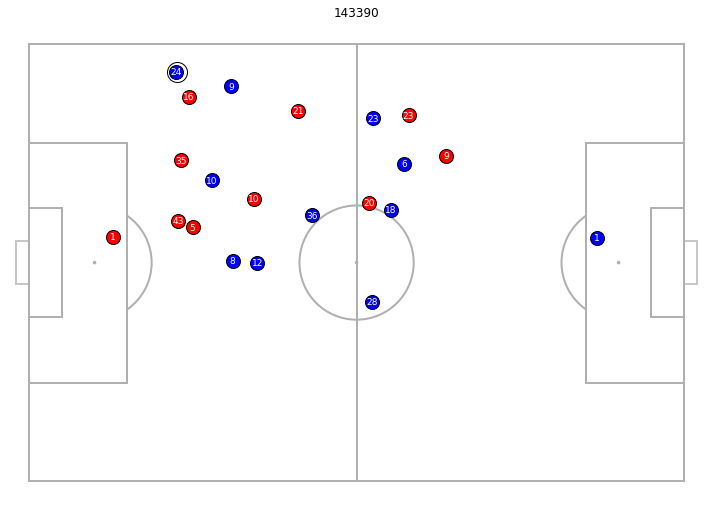

time: 28.7 s


In [41]:
flag_0 = flag_1 = True
t0_x = t0_y = t1_x = t1_y = pd.Series(dtype=float)
def animate_shot(starting_frame, ending_frame, SOU_team):
    ##### Animate the Section to Understand 
    from matplotlib import animation
    from mplsoccer.pitch import Pitch
    import matplotlib.pyplot as plt

    # Set up formatting for the movie files
    import matplotlib.animation as animation
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1
    
    frames_to_animate = list(range(starting_frame, ending_frame))

    pitch = Pitch(pitch_type='statsbomb',orientation='horizontal',view='full',layout=(1,1), figsize=(10.8, 7.2),
                  pitch_width=105,pitch_length=68,stripe=False,goal_type='box', axis=False, label=True)
    fig, ax = pitch.draw()

    ball, = ax.plot([], [], 'ko', ms=9,markerfacecolor='yellow')
    team_0, = ax.plot([], [], 'ko', ms=14,markerfacecolor='blue',alpha=1) 
    team_1, = ax.plot([], [], 'ko', ms=14,markerfacecolor='red',alpha=1)
    hollow, = ax.plot([], [], 'ko', ms=20,markerfacecolor='none',alpha=1)
    
    # initialization function: plot the background of each frame
    def init():
        ball.set_data([], [])
        team_0.set_data([], [])
        team_1.set_data([], [])
        hollow.set_data([],[])
        return ball, team_0, team_1,hollow
    
    annotations = []
    # arrows = []
    
    # animation function of dataframes' list

    
    def animate(i):
        ax.set_title(str(frames_to_animate[i]))
        global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1

        frame_ = tracking[tracking['frameIdx'] == frames_to_animate[i]]
        ball_ = frame_[frame_['Team_Name'] == 'BALL'].reset_index()
        # ball_ = frame_[frame_['playerId'] == 'BALL'].reset_index()
        hollow_ = frame_[frame_['Team_Name'] == 'BALL'].reset_index()
        
        team0_ = frame_[(frame_['Team_Name'] != 'SOU') & (frame_['Team_Name'] != 'BALL')].reset_index()
        number0_ = frame_[(frame_['Team_Name'] != 'SOU') & (frame_['Team_Name'] != 'BALL')].reset_index()[['number']]
        
        team1_ = frame_[frame_['Team_Name'] == 'SOU'].reset_index()
        number1_ = frame_[frame_['Team_Name'] == 'SOU'].reset_index()[['number']]
        
        number0_.number = number0_.number.apply(lambda x: int(x))
        number1_.number = number1_.number.apply(lambda x: int(x))
        
        # set the ball data with the x and y positions for the ith frame
        ball.set_data(hollow_.ball_x1, hollow_.ball_y1)
        hollow.set_data(hollow_.ball_x1, hollow_.ball_y1)
        
        # set the player data using the frame id
        team_0.set_data(team0_.x1,team0_.y1)
        team_1.set_data(team1_.x1,team1_.y1)
        
        for i, a in enumerate(annotations):
            a.remove()
        annotations[:] = []
#         for i, a in enumerate(arrows):
#             a.remove()
        
#         arrows[:] = []
        
        # update for team 0
        for k in range(len(team0_)):
            try:
                annot1 = pitch.annotate(number0_.number[k], (team0_.x1[k], team0_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot1)

#                 arr1 = pitch.arrows(team0_.x1[k], team0_.y1[k],
#                                     t0_x[k] + team0_.speed[k], t0_y[k] - team0_.speed[k],                                    
#                                     width=2, headwidth=10, headlength=10, color='#ad993c', ax=ax)
#                 arrows.append(arr1)                
            except Exception as ex:
                pass
            t0_x = team0_.x1
            t0_y = team0_.y1
        
        # update for team 1
        for k in range(len(team1_)):
            try:
                annot2 = pitch.annotate(number1_.number[k], (team1_.x1[k], team1_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot2)
#                 arr2 = pitch.arrows(team1_.x1[k], team1_.y1[k],
#                                     t1_x[k] + team1_.speed[k], t1_y[k] - team1_.speed[k],                                    
#                                     width=2, headwidth=5, headlength=5, color='#ad993c', ax=ax)                    

#                 arrows.append(arr2)                
            except Exception as ex:
                pass
            t1_x = team1_.x1
            t1_y = team1_.y1
             
        
        ax.set_xlim(-4,124)
        ax.set_ylim(-4,84)
        #ax.axvline(x=40,alpha=0.1,color="beige")
        #ax.axvline(x=80,alpha=0.1,color="beige")
        #ax.axhline(y=12,alpha=0.1,color="beige")
        #ax.axhline(y=26,alpha=0.1,color="beige")
        #ax.axhline(y=54,alpha=0.1,color="beige")
        #ax.axhline(y=68,alpha=0.1,color="beige")
        
        
        return ball, team_0, team_1,hollow,
    
    # call the animator, animate every 300 ms
    # note that its hard to get the ffmpeg requirements right. I installed from conda-forge: see the conda.yml file
    anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_animate), init_func=init, interval=25, blit=True)
    return(anim)


anim = animate_shot(143301,143391, 1).to_html5_video()
HTML(anim)



In [ ]:
l=Closest_points3.number1

#L = [item for sublist in l for item in sublist]
flatten = lambda l: [item for sublist in l  for item in sublist]
groups = [list(group) for key, group in itertools.groupby(l, len)]
groups

In [ ]:
import itertools
flatten = itertools.chain.from_iterable

a=list(flatten(Closest_points3['Sou_Players']))
Player_involvement=pd.DataFrame(flatten(a)).set_axis(['Involvment'], axis=1, inplace=False)
Player_involvement.Involvment.value_counts() 

In [ ]:
import itertools
flatten = itertools.chain.from_iterable

a=list(flatten(Closest_points3['y_zone']))
zone_involvement=pd.DataFrame(flatten(a)).set_axis(['involvement'], axis=1, inplace=False)
zone_involvement.involvement.value_counts() 

In [ ]:
##### Which players are involved in Creating Overloads the most? #########

zone_involvement.involvement.value_counts() .nlargest(5).plot(kind='barh', figsize=(8, 6))
#plt.rcParams['axes.facecolor'] = 'white'
#plt.set_facecolor('white')
plt.xlabel("Overload Zones", labelpad=14)
plt.ylabel("Number of Overloads", labelpad=20)
plt.title("Overloads created by Southampton", y=1.02);

In [ ]:

Closest_points3.Sou_Players.value_counts().nlargest(5).plot(kind='barh', figsize=(8, 6))
#plt.rcParams['axes.facecolor'] = 'white'
#plt.set_facecolor('white')
plt.xlabel("Overload Zones", labelpad=14)
plt.ylabel("Number of Overloads", labelpad=20)
plt.title("Overloads created by Southampton", y=1.02);

C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\mplsoccer\pitch.py:380: UserWarning: Labels will not be shown unless axis=True
  warnings.warn("Labels will not be shown unless axis=True")
C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\mplsoccer\pitch.py:387: UserWarning: Pitch length and widths are only used for tracab pitches and will be ignored
  warnings.warn("Pitch length and widths are only used for tracab pitches and will be ignored")


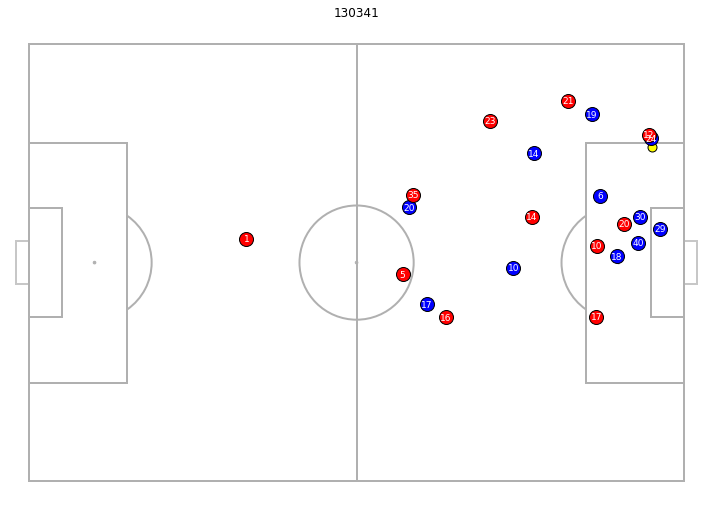

time: 1min 32s


In [260]:
flag_0 = flag_1 = True
t0_x = t0_y = t1_x = t1_y = pd.Series(dtype=float)
def animate_shot(starting_frame, ending_frame, SOU_team):
    ##### Animate the Section to Understand 
    from matplotlib import animation
    from mplsoccer.pitch import Pitch
    import matplotlib.pyplot as plt

    # Set up formatting for the movie files
    import matplotlib.animation as animation
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1
    
    frames_to_animate = list(range(starting_frame, ending_frame))

    pitch = Pitch(pitch_type='statsbomb',orientation='horizontal',view='full',layout=(1,1), figsize=(10.8, 7.2),
                  pitch_width=105,pitch_length=68,stripe=False,goal_type='box', axis=False, label=True)
    fig, ax = pitch.draw()

    ball, = ax.plot([], [], 'ko', ms=9,markerfacecolor='yellow')
    team_0, = ax.plot([], [], 'ko', ms=14,markerfacecolor='blue',alpha=1) 
    team_1, = ax.plot([], [], 'ko', ms=14,markerfacecolor='red',alpha=1)
    
    # initialization function: plot the background of each frame
    def init():
        ball.set_data([], [])
        team_0.set_data([], [])
        team_1.set_data([], [])
        return ball, team_0, team_1
    
    annotations = []
    # arrows = []
    
    # animation function of dataframes' list

    
    def animate(i):
        ax.set_title(str(frames_to_animate[i]))
        global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1

        frame_ = tracking[tracking['frameIdx'] == frames_to_animate[i]]
        ball_ = frame_[frame_['Team_Name'] == 'BALL'].reset_index()
        # ball_ = frame_[frame_['playerId'] == 'BALL'].reset_index()
        
        team0_ = frame_[(frame_['Team_Name'] != 'SOU') & (frame_['Team_Name'] != 'BALL')].reset_index()
        number0_ = frame_[(frame_['Team_Name'] != 'SOU') & (frame_['Team_Name'] != 'BALL')].reset_index()[['number']]
        
        team1_ = frame_[frame_['Team_Name'] == 'SOU'].reset_index()
        number1_ = frame_[frame_['Team_Name'] == 'SOU'].reset_index()[['number']]
        
        number0_.number = number0_.number.apply(lambda x: int(x))
        number1_.number = number1_.number.apply(lambda x: int(x))
        
        # set the ball data with the x and y positions for the ith frame
        ball.set_data(ball_.ball_x1, ball_.ball_y1)
        
        # set the player data using the frame id
        team_0.set_data(team0_.x1,team0_.y1)
        team_1.set_data(team1_.x1,team1_.y1)
        
        for i, a in enumerate(annotations):
            a.remove()
        annotations[:] = []
#         for i, a in enumerate(arrows):
#             a.remove()
        
#         arrows[:] = []
        
        # update for team 0
        for k in range(len(team0_)):
            try:
                annot1 = pitch.annotate(number0_.number[k], (team0_.x1[k], team0_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot1)

#                 arr1 = pitch.arrows(team0_.x1[k], team0_.y1[k],
#                                     t0_x[k] + team0_.speed[k], t0_y[k] - team0_.speed[k],                                    
#                                     width=2, headwidth=10, headlength=10, color='#ad993c', ax=ax)
#                 arrows.append(arr1)                
            except Exception as ex:
                pass
            t0_x = team0_.x1
            t0_y = team0_.y1
        
        # update for team 1
        for k in range(len(team1_)):
            try:
                annot2 = pitch.annotate(number1_.number[k], (team1_.x1[k], team1_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot2)
#                 arr2 = pitch.arrows(team1_.x1[k], team1_.y1[k],
#                                     t1_x[k] + team1_.speed[k], t1_y[k] - team1_.speed[k],                                    
#                                     width=2, headwidth=5, headlength=5, color='#ad993c', ax=ax)                    

#                 arrows.append(arr2)                
            except Exception as ex:
                pass
            t1_x = team1_.x1
            t1_y = team1_.y1
        
               
        
        ax.set_xlim(-4,124)
        ax.set_ylim(-4,84)
        #ax.axvline(x=40,alpha=0.1,color="beige")
        #ax.axvline(x=80,alpha=0.1,color="beige")
        #ax.axhline(y=12,alpha=0.1,color="beige")
        #ax.axhline(y=26,alpha=0.1,color="beige")
        #ax.axhline(y=54,alpha=0.1,color="beige")
        #ax.axhline(y=68,alpha=0.1,color="beige")
        
        
        return ball, team_0, team_1
    
    # call the animator, animate every 300 ms
    # note that its hard to get the ffmpeg requirements right. I installed from conda-forge: see the conda.yml file
    anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_animate), init_func=init, interval=25, blit=True)
    return(anim)

anim = animate_shot(130002,130342, 1).to_html5_video()
HTML(anim)



## The Overload Framework


We look to create overloads in wide areas, this is classified within .... 

In [153]:

ol_sum_start = []
ol_sum_end = []
ol_sum_type = []
ol_sum_side = []
ol_sum_lb_sequence_id = []
ol_sum_overload_id = []
ol_sum_duration = []
 

for iii in range(len(lb_sequence_summary)):
# grab a segment of tracking for the lb_segment
    lg_seg_idx = iii
    lb_select = lb_sequence_summary.iloc[lg_seg_idx]

    lb_seg = tracking1[tracking1['frameIdx'].between(lb_select.frameID_start,lb_select.frameID_end)].reset_index(drop=True)

    ball_seg = lb_seg[lb_seg['Team_Name'] == 'BALL'].reset_index()
    team0_seg = lb_seg[(lb_seg['Team_Name1'] == 'OPP')].reset_index()
    team1_seg = lb_seg[lb_seg['Team_Name1'] == 'SOU '].reset_index()

    ## work out the wide zones 

    ''' 
    Attacking direction of 1 means the team is defending the goal -x and attacking the goal +x. 
    An attacking direction of -1 means the team is defending the goal +x and attacking the goal -x.
    '''

    lb_att_dir = team1_seg.iloc[0]['Direction']

#     print("att_dir", lb_att_dir)

    
    if lb_att_dir == -1:

        wide_left_xmin = 0
        wide_left_xmax = 60
        wide_left_ymin = 55
        wide_left_ymax = 80

        wide_right_xmin = 0
        wide_right_xmax = 60
        wide_right_ymin = 0
        wide_right_ymax = 25


    elif lb_att_dir == 1:

        wide_left_xmin = -60
        wide_left_xmax = 0
        wide_left_ymin = 0
        wide_left_ymax = 25

        wide_right_xmin = -60
        wide_right_xmax = 0
        wide_right_ymin = 55
        wide_right_ymax = 80

    else:
        print("ERROR WITH ATTACKING DIRECTION")  
        
    frames_list = []
    wide_left_list = []
    wide_right_list = []

    for bf in list(set(ball_seg.frameIdx)):

        row_ = ball_seg[ball_seg['frameIdx'] == bf].reset_index(drop=True).iloc[0]

        if (row_['y'] >= wide_left_ymin) and (row_['y'] <= wide_left_ymax):
            if (row_['x'] >= wide_left_xmin) and (row_['x'] <= wide_left_xmax):
                wide_left_list.append(True)
            else: 
                wide_left_list.append(False)
        else: 
            wide_left_list.append(False)

        if (row_['y'] >= wide_right_ymin) and (row_['y'] <= wide_right_ymax):
            if (row_['x'] >= wide_right_xmin) and (row_['x'] <= wide_right_xmax):
                wide_right_list.append(True)
            else: 
                wide_right_list.append(False)
        else: 
            wide_right_list.append(False)

        frames_list.append(bf)
        
        
    overload_calcs = pd.DataFrame(
        {'frameID': frames_list,
         'wide_right': wide_right_list,
         'wide_left': wide_left_list
        })
    
    # check for overload in wide_left 
    overload_calcs_left = overload_calcs[overload_calcs['wide_left'] == True].frameID
    overload_left_list = []
    overload_left_type_list = []

    for f in overload_calcs.frameID:

        if overload_calcs[overload_calcs['frameID'] == f].reset_index(drop=True).iloc[0]['wide_left'] == True:

            fcn = team1_seg[team1_seg['frameIdx'] == f].reset_index(drop=True)
            oppo = team0_seg[team0_seg['frameIdx'] == f].reset_index(drop=True)

            ## count FCN players 
            fcn_ = fcn[(fcn['y']  >= wide_left_ymin) & (fcn['y'] <= wide_left_ymax)]
            fcn_ = fcn_[(fcn_['x'] >= wide_left_xmin) & (fcn_['x'] <= wide_left_xmax)]

            ## count FCN players 
            oppo_ = oppo[(oppo['y']  >= wide_left_ymin) & (oppo['y'] <= wide_left_ymax)]
            oppo_ = oppo_[(oppo_['x'] >= wide_left_xmin) & (oppo_['x'] <= wide_left_xmax)]


            if (len(fcn_) >= len(oppo_)):
                if len(fcn_) >= 3:
                    overload_left_list.append(True)
                    overload_left_type_list.append(str(len(fcn_)) + "v" + str(len(oppo_)))
                else: 
                    overload_left_list.append(False)
                    overload_left_type_list.append("")
            else:
                overload_left_list.append(False)
                overload_left_type_list.append("")
        else:
            overload_left_list.append(False)    
            overload_left_type_list.append("")


    overload_calcs['left_overload'] = overload_left_list
    overload_calcs['left_overload_type'] = overload_left_type_list
    
    
    ### right
    overload_calcs_right = overload_calcs[overload_calcs['wide_right'] == True].frameID
    overload_right_list = []
    overload_right_type_list = []

    for f in overload_calcs.frameID:

        if overload_calcs[overload_calcs['frameID'] == f].reset_index(drop=True).iloc[0]['wide_right'] == True:

            fcn = team1_seg[team1_seg['frameIdx'] == f].reset_index(drop=True)
            oppo = team0_seg[team0_seg['frameIdx'] == f].reset_index(drop=True)

            ## count FCN players 
            fcn_ = fcn[(fcn['y']  >= wide_right_ymin) & (fcn['y'] <= wide_right_ymax)]
            fcn_ = fcn_[(fcn_['x'] >= wide_right_xmin) & (fcn_['x'] <= wide_right_xmax)]

            ## count FCN players 
            oppo_ = oppo[(oppo['y']  >= wide_right_ymin) & (oppo['y'] <= wide_right_ymax)]
            oppo_ = oppo_[(oppo_['x'] >= wide_right_xmin) & (oppo_['x'] <= wide_right_xmax)]


            if (len(fcn_) >= len(oppo_)):
                if len(fcn_) >= 3:
                    overload_right_list.append(True)
                    overload_right_type_list.append(str(len(fcn_)) + "v" + str(len(oppo_)))
                else: 
                    overload_right_list.append(False)
                    overload_right_type_list.append("")
            else:
                overload_right_list.append(False)
                overload_right_type_list.append("")
        else:
            overload_right_list.append(False)    
            overload_right_type_list.append("")


    overload_calcs['right_overload'] = overload_right_list
    overload_calcs['right_overload_type'] = overload_right_type_list
    
    overload_calcs2 = overload_calcs[(overload_calcs['left_overload'] == True) | (overload_calcs['right_overload'] == True)].reset_index(drop=True)
    
        
    
    ## combine the left and right valued just to side and type
    side_list = []
    type_list = []
    
    for j in list(range(len(overload_calcs2))):
    
        if overload_calcs2.iloc[j].left_overload == True:
            side_list.append("left")
            type_list.append(overload_calcs2.iloc[j].left_overload_type)
        else:
            side_list.append("right")
            type_list.append(overload_calcs2.iloc[j].right_overload_type)
    
    overload_calcs2['type'] = type_list
    overload_calcs2['side'] =  side_list  
    
    ## reduce the calcs to just the essentials 
    overload_calcs2 = overload_calcs2[['frameID', 'type', 'side']]
    overload_calcs2['lb_sequence_id'] = lb_select.lb_sequence_id
    
    if len(overload_calcs2) > 0:
        ## add the id 
        overload_id = 1
        overload_id_list = [str(lb_select.lb_sequence_id) + "_" + str(1)]

        for j in list(range(1, len(overload_calcs2))):

            if (overload_calcs2.iloc[j].frameID - overload_calcs2.iloc[j-1].frameID) <= 50:
                overload_id_list.append(str(overload_calcs2.iloc[j].lb_sequence_id) + "_" + str(overload_id))
            else:
                overload_id += 1
                overload_id_list.append(str(overload_calcs2.iloc[j].lb_sequence_id) + "_" + str(overload_id))

        overload_calcs2['overload_id'] = overload_id_list
        
    
        for g in list(set(overload_calcs2.overload_id)):  
    
            ol_sum_start.append(overload_calcs2[overload_calcs2['overload_id'] == g]['frameID'].min())
            ol_sum_end.append(overload_calcs2[overload_calcs2['overload_id'] == g]['frameID'].max())
            ol_sum_type.append(overload_calcs2[overload_calcs2['overload_id'] == g].reset_index(drop=True).iloc[0]['type'])
            ol_sum_side.append(overload_calcs2[overload_calcs2['overload_id'] == g].reset_index(drop=True).iloc[0]['side'])
            ol_sum_lb_sequence_id.append(overload_calcs2.iloc[0]['lb_sequence_id'])
            ol_sum_overload_id.append(g)
            ol_sum_duration.append(overload_calcs2[overload_calcs2['overload_id'] == g]['frameID'].max() - overload_calcs2[overload_calcs2['overload_id'] == g]['frameID'].min())


overload_results = pd.DataFrame({'start': ol_sum_start, 
                                'end': ol_sum_end, 
                                'type': ol_sum_type, 
                                'side': ol_sum_side, 
                                'lb_sequence_id': ol_sum_lb_sequence_id, 
                                'strategy_id': ol_sum_overload_id, 
                                'duration': ol_sum_duration})

overload_results = overload_results[overload_results['duration'] > 50].reset_index(drop=True)


overload_results['strategy_id'] = ["ol_" + f for f in overload_results['strategy_id']]
overload_results['strategy_type'] = "overload"
overload_results
#print("overload_results - head")
#print(overload_results)


start    end type   side  lb_sequence_id strategy_id  duration  \
0  69516  69851  7v7   left              29     ol_29_1       335   
1  74028  74143  7v7  right              32     ol_32_1       115   
2  84668  84727  8v8  right              40     ol_40_1        59   

  strategy_type  
0      overload  
1      overload  
2      overload

time: 40.3 s


In [ ]:
################ When Southampton Defending? #####################

In [26]:

####################### Pressure Zones  ######################################

from scipy.spatial import KDTree
from collections import Counter

a=[]
b=[]
c=[]
d=[]
e=[]
f=[]

for frame_select in lb_sequence_summary_frames:
    
    track_seg2 = tracking[tracking.frameIdx == frame_select]
    
    track_seg3=track_seg2[(track_seg2['rank']<8) & (track_seg2['distance_to_ball']<10)]
    
    #track_seg3=track_seg3[~(track_seg3['y_zone'].isin(['Middle',np.nan]))]
    team=track_seg3[~(track_seg3['Team_Name1']=='BALL')]
    team1=team[['Team_Name1']]
    name=team[['name']].T
    name=name.values
    teamx=track_seg3[track_seg3['Team_Name']=='SOU ']
    SOU_name=teamx[['name']].T
    SOU_name=SOU_name.values
    team3=track_seg3[(track_seg3['Team_Name1']=='BALL')]
    y_zone=team3[['y_zone']].T
    y_zone=y_zone.values
    rank=team[['rank']].T
    rank=rank.values
    number=teamx[['number']].T
    number1=number.values
    number1=number1.astype(int)
    value_counts=Counter(team1.Team_Name1)
    
    a.append(number1)
    b.append(frame_select)
    c.append(rank)
    d.append(value_counts)
    e.append(y_zone)
    f.append(SOU_name)
    
Closest_points = pd.DataFrame(
        {'frameID': b,
         'number1': a,
         'rank': c,
         'value_counts': d,
         'y_zone': e,
         'Sou_Players':f
        })

Closest_points=pd.merge(Closest_points,df, left_on='frameID', right_on='number', how='left')
overloads=pd.DataFrame(Closest_points['value_counts'].values.tolist())
Closest_points=pd.merge(Closest_points,overloads, left_index=True, right_index=True, how='left')
#Closest_points1['Opposition']
Closest_points1=Closest_points.loc[(Closest_points['SOU ']-Closest_points['OPP'] <=1) & (Closest_points['SOU ']-Closest_points['OPP'] >0)]
Closest_points2=Closest_points1[Closest_points1['SOU ']>2]

#Closest_points_CHECK1=Closest_points_CHECK[Closest_points_CHECK['lb_sequence_id']==11]

Closest_points2['OPP']=Closest_points2['OPP'].astype(int)
Closest_points2['SOU ']=Closest_points2['SOU '].astype(int)

#Closest_points2['Overload']=str(Closest_points2['SOU '])+'v'+str(Closest_points2['OPP'])
cols=['SOU ','OPP']
Closest_points2['Pressure_Overload'] = Closest_points2[cols].apply(lambda row: 'v'.join(row.values.astype(str)), axis=1)
#Closest_points3=Closest_points2[['y_zone','Overload','lb_sequence_id']]
Closest_points3=Closest_points2.loc[Closest_points2['y_zone'] != Closest_points2['y_zone'].shift(1)]

time: 1min 20s


C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [115]:
################# Runs against Southampton #################


printer = True
all_run_sequence_summary = pd.DataFrame()

for j in list(range(len(lb_sequence_summary))):
           
    #RR = 19
    ## select the low block sequence 
    lg_seg_idx = j
#     print(RR)
    lb_select = lb_sequence_summary.iloc[lg_seg_idx]
    
#     print(lb_select.lb_sequence_id)

#     print("/")
        
    ## create a segment of tracking segment
    lb_seg = tracking[(tracking['frameIdx'].between(lb_select.frameID_start,lb_select.frameID_end + 75)) & (tracking['live'] == True)].reset_index(drop=True)

    ## find defensive line 
    last_line=['LCB','RCB','LB','RB']
    oppo_seg = lb_seg[(lb_seg['Team_Name1'] == 'SOU ') & (lb_seg['position'].isin(last_line))].reset_index(drop=True)

    ## get attacking direction of defensive team 
    att_dir = oppo_seg.iloc[0]['Direction']
    
    ## calculate the defensive line
    frame_list = []
    def_line_list = []

    ## loop through and get the defensive line for each frame
    for fr in list(set(oppo_seg.frameIdx)):
        
        frame_list.append(fr) # append the frame 
        temp_seg = oppo_seg[oppo_seg['frameIdx'] == fr].reset_index(drop=True)
        #defensive_seg=temp_seg[temp_seg['position'].isin(last_line)].reset_index(drop=True)

        if att_dir == -1:
            temp_seg = temp_seg.sort_values(by=['frameIdx', 'x1'], ascending=[True, True]).reset_index(drop=True)
        else: 
            temp_seg = temp_seg.sort_values(by=['frameIdx', 'x1'], ascending=[True,False]).reset_index(drop=True)

        def_line_list.append(temp_seg.iloc[0:2]['x1'].mean()) # append the defensive last line
        
    
    ## create a summary dataframe 
    the_view = pd.DataFrame({'frameIdx': frame_list,'def_line': def_line_list})
    
    lb_seg['Direction'] = att_dir # add attacking direction used 
    lb_seg = pd.merge(lb_seg, the_view, on="frameIdx",how='left') # merge together so the defensive line appears as a new column
    ## find defensive line 
    fcn_seg = lb_seg[lb_seg['Team_Name1'] == 'OPP'].reset_index(drop=True)

#     if printer:
#         print(fcn_seg.head())    
#         printer = False
#     print("list(set(fcn_seg['player_id']))", len(list(set(fcn_seg['player_id']))))
    
    for player in list(set(fcn_seg['number'])):
        
#         print(player, "in", lb_select.lb_sequence_id)
        
        player_seg = fcn_seg[fcn_seg['number'] == player].reset_index(drop=True)
        player_seg['next_x1'] = player_seg['x1'].shift(-1)
        player_seg['next_speed'] = player_seg['speed'].shift(-1)
#         print("player_seg.iloc[0]['attacking_direction']", player_seg.iloc[0]['attacking_direction'])
        if player_seg.iloc[0]['Direction'] == -1:
            player_seg['direction']=np.where((player_seg['x1'] < player_seg['next_x1']),1,0)
            player_seg['close_to_def_line']=np.where( ( abs(player_seg['def_line'] - player_seg['x1']) <= 8),1,0)
            player_seg['in_front_of_line']=np.where( (player_seg['def_line'] > player_seg['x1']),1,0)
            player_seg['run_broken_line']=np.where((player_seg['def_line']< player_seg['x1']),1,0)
            player_seg['on_ball']=np.where((player_seg['distance_to_ball']<= 0.8),1,0)
#             player_seg['vertical_gain_5']=np.where( ((player_seg['next_x'] - player_seg['x']) > 5) ,1,0)
            player_seg['vertical_gain']=np.where( ((player_seg['next_speed'] - player_seg['speed']) > 0.1) ,1,0)


        elif player_seg.iloc[0]['Direction'] == 1:
            player_seg['direction']=np.where((player_seg['x1'] > player_seg['next_x1']),1,0)
            player_seg['close_to_def_line']=np.where( (abs(player_seg['def_line'] - player_seg['x1']) >= -8),1,0)
            player_seg['in_front_of_line']=np.where( (player_seg['def_line'] < player_seg['x1']),1,0)
            player_seg['run_broken_line']=np.where((player_seg['def_line']>player_seg['x1']),1,0)
            player_seg['on_ball']=np.where((player_seg['distance_to_ball']<= 0.8),1,0)
#             player_seg['vertical_gain_5']=np.where( ((player_seg['next_x'] - player_seg['x']) < -5) ,1,0)
            player_seg['vertical_gain']=np.where( ((player_seg['next_speed'] - player_seg['speed']) > 0.1) ,1,0)


        speeds = ['jogging','low_speed_running' , 'high_speed_running','high_speed_sprinting', 'low_speed_sprinting']    
        player_seg['run_speed'] =  np.where((player_seg['speed_class'].isin(speeds)),1,0)
#         player_seg['forward_run_5'] = np.where((  (player_seg['Direction'] == 1)  & (player_seg['vertical_gain_5'] == 1) & (player_seg['dist_to_def_line']  == 1) & (player_seg['run_speed'] == 1) ), 1, 0)
        player_seg['forward_run'] = np.where((  (player_seg['direction'] == 1)  & (player_seg['close_to_def_line'] == 1) & (player_seg['vertical_gain'] == 1) & (player_seg['in_front_of_line']  == 1) & (player_seg['run_speed'] == 1) ), 1, 0)
        
#         if printer:
#             print("'frameID', 'x', 'y', 'vertical_gain', 'on_ball', 'forward_run'")
#             print(player_seg[['frameID', 'x', 'vertical_gain',  'forward_run', 'in_front_of_line', 'close_to_def_line', 'def_line']])    
#             printer = False
#         if lb_select.lb_sequence_id == 17:
            
        print_boi = True
        
        if len(list(set(player_seg.forward_run))) > 1:
#             print("*"*80)
            
            ## bridge gaps in runs of 12 frames 
            run_happening = []
            for ii in list(range(0, len(player_seg) - 12)):
                run_happening.append( int( (1 in list(set(player_seg.iloc[ii:ii+12].forward_run))) == True) )
            player_seg['forward_run2'] = run_happening + list(player_seg.iloc[len(player_seg)-12:len(player_seg)].forward_run)


        
            runs_frameIDs = list(player_seg[player_seg['forward_run2'] == 1].frameIdx)
            
            gap_threshold = 12 # under 100 frames = 4 seconds 
            run_sequence_id = 1

            run_sequence_id_list = [1]

            for run_frame in range(1,len(runs_frameIDs)):

                    if (runs_frameIDs[run_frame] - runs_frameIDs[run_frame-1]) <= gap_threshold:

                        run_sequence_id_list.append(run_sequence_id)

                    else:
                        run_sequence_id = run_sequence_id + 1
                        run_sequence_id_list.append(run_sequence_id)
            run_sequence_info = pd.DataFrame(
                {'frameIdx': runs_frameIDs,
                 'run_sequence_id': run_sequence_id_list
                })

            
            start__ = []
            end__ = []
            past_line__ = []
            break_line__ = []
            player_id__ = []
            run_id__ = []
            median_y__ = []
            
            for s in list(set(run_sequence_info.run_sequence_id)):
                
                start_frame = run_sequence_info[run_sequence_info['run_sequence_id'] == s].frameIdx.min()
                end_frame = run_sequence_info[run_sequence_info['run_sequence_id'] == s].frameIdx.max()

                start__.append(start_frame)
                end__.append(end_frame)
                
                run_seg = player_seg[player_seg['frameIdx'].between(start_frame, end_frame)]
                median_y__.append(round(run_seg.y.median(),0))

                player_id__.append(player)
                run_id__.append(s)

            
            run_sequence_summary = pd.DataFrame(
                {'start': start__,
                 'end': end__,
                 'player_id' : player_id__,
                 'run_id' :run_id__,
                 'median_y':median_y__
                })
            
            
            in_behind_scope = 5
            on_ball_scope = 100 
            
            
            in_behind__ = []
            on_ball__ = [] 
            
            for r in list(range(len(run_sequence_summary))):
                
                run_info = run_sequence_summary.iloc[r]
                in_behind__.append(1 in set(player_seg[player_seg['frameIdx'].between(run_info.start, run_info.end + in_behind_scope)].run_broken_line))
                on_ball__.append(1 in set(player_seg[player_seg['frameIdx'].between(run_info.start, run_info.end + on_ball_scope)].on_ball))   

            run_sequence_summary['in_behind'] = in_behind__
            run_sequence_summary['on_ball'] = on_ball__            
            run_sequence_summary['lb_sequence_id'] = lb_select.lb_sequence_id

            all_run_sequence_summary = all_run_sequence_summary.append(run_sequence_summary)

all_run_sequence_summary['strategy_id'] = ["r_" + str(a) + "_" + str(b) for a,b in zip(all_run_sequence_summary['lb_sequence_id'] , all_run_sequence_summary['run_id'])]
all_run_sequence_summary['strategy_type'] = "run"
all_run_sequence_summary = all_run_sequence_summary.reset_index(drop=True)

del all_run_sequence_summary['run_id']


all_run_sequence_summary




   

start     end  player_id  median_y  in_behind  on_ball  lb_sequence_id  \
0    45124   45140         12     -12.0       True    False              19   
1    48946   48965         12      -0.0      False    False              23   
2    50037   50048         19     -19.0       True    False              23   
3    50182   50193         12       3.0      False    False              24   
4    57142   57153         12       1.0       True    False              28   
5    88753   88764         19      14.0      False    False              47   
6    90867   90878         12       5.0       True    False              48   
7    91078   91091         19      13.0      False    False              48   
8   107921  107933         10       9.0      False    False              57   
9   107982  107993         12       2.0      False    False              57   
10  108422  108435          9      -4.0       True    False              58   
11  108706  108727         12       0.0      False    False              58   
12  111755  111778         19      26.0      False    False              63   
13  112285  112305         28     -23.0      False    False              64   
14  133799  133823         10     -24.0      False    False              74   
15  133178  133207         12       8.0      False    False              74   
16  133793  133832         12       4.0      False    False              74   
17  134143  134154          9      15.0       True     True              75   
18  134073  134099         12       2.0      False    False              75   
19  137453  137469         12      -3.0      False    False              77   

   strategy_id strategy_type  
0       r_19_1           run  
1       r_23_1           run  
2       r_23_1           run  
3       r_24_1           run  
4       r_28_1           run  
5       r_47_1           run  
6       r_48_1           run  
7       r_48_1           run  
8       r_57_1           run  
9       r_57_1           run  
10      r_58_1           run  
11      r_58_1           run  
12      r_63_1           run  
13      r_64_1           run  
14      r_74_1           run  
15      r_74_1           run  
16      r_74_2           run  
17      r_75_1           run  
18      r_75_1           run  
19      r_77_1           run

time: 2min 3s


In [ ]:
#Plot the frames
from matplotlib.figure import Figure
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
from matplotlib import style
from scipy.spatial import ConvexHull

import random
import warnings
warnings.filterwarnings(action='once')

#samples = random.sample(a, 5)

#for frame_select in samples:

frame_select = 107798

track_seg = tracking[tracking.frameIdx == frame_select].reset_index(drop=True)

team_1_seg = track_seg[(track_seg['Team_Name'] == 'SOU ')].reset_index()
team_0_seg = track_seg[(track_seg['Team_Name'] == ' NEW ')].reset_index()
ball_seg = track_seg[track_seg['Team_Name'] == 'BALL'].reset_index()

pitch = Pitch(pitch_type='statsbomb',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
              pitch_width=68,pitch_length=105,stripe=False,goal_type='box',axis=True,label=True)
fig, ax = pitch.draw()

ball, = ax.plot(ball_seg.x1, ball_seg.y1, 'ko', ms=12,markerfacecolor='yellow',zorder=10)
team_0, = ax.plot(team_0_seg.x1, team_0_seg.y1, 'ko', ms=20,markerfacecolor='blue') #red/maroon
team_1, = ax.plot(team_1_seg.x1, team_1_seg.y1, 'ko', ms=20,markerfacecolor='red') #purple


team_0, = ax.plot(team_1_seg.x1.mean(), team_1_seg.y1.mean(), 'ko', ms=10,markerfacecolor='green') #red/maroon
plt.title(str(frame_select))
plt.show()

#

C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\mplsoccer\pitch2.py:387: UserWarning: Pitch length and widths are only used for tracab pitches and will be ignored
  warnings.warn("Pitch length and widths are only used for tracab pitches and will be ignored")


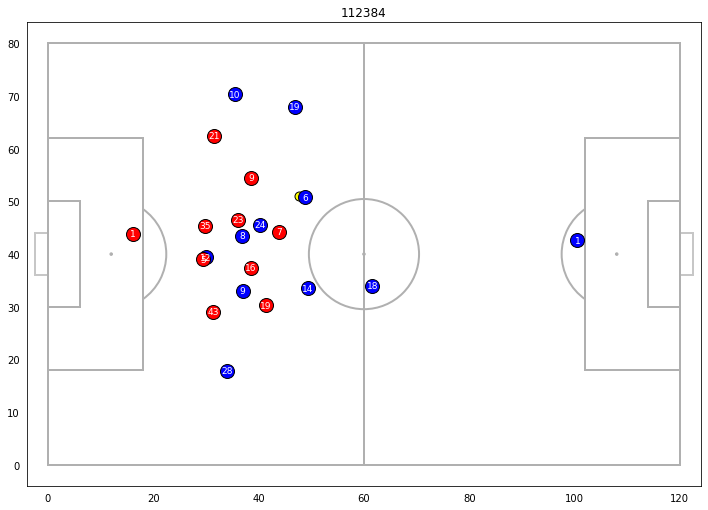

time: 1min 2s


In [116]:
flag_0 = flag_1 = True
t0_x = t0_y = t1_x = t1_y = pd.Series(dtype=float)
def animate_shot(starting_frame, ending_frame, SOU_team):
    ##### Animate the Section to Understand 
    from matplotlib import animation
    from mplsoccer.pitch2 import Pitch
    import matplotlib.pyplot as plt

    # Set up formatting for the movie files
    import matplotlib.animation as animation
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1
    
    frames_to_animate = list(range(starting_frame, ending_frame))

    pitch = Pitch(pitch_type='statsbomb',orientation='horizontal',view='full',layout=(1,1), figsize=(10.8, 7.2),
                  pitch_width=105,pitch_length=68,stripe=False,goal_type='box', axis=True, label=True)
    fig, ax = pitch.draw()

    ball, = ax.plot([], [], 'ko', ms=9,markerfacecolor='yellow')
    team_0, = ax.plot([], [], 'ko', ms=14,markerfacecolor='blue',alpha=1) 
    team_1, = ax.plot([], [], 'ko', ms=14,markerfacecolor='red',alpha=1)
    
    # initialization function: plot the background of each frame
    def init():
        ball.set_data([], [])
        team_0.set_data([], [])
        team_1.set_data([], [])
        return ball, team_0, team_1
    
    annotations = []
    # arrows = []
    
    # animation function of dataframes' list

    
    def animate(i):
        ax.set_title(str(frames_to_animate[i]))
        global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1

        frame_ = tracking[tracking['frameIdx'] == frames_to_animate[i]]
        ball_ = frame_[frame_['Team_Name'] == 'BALL'].reset_index()
        # ball_ = frame_[frame_['playerId'] == 'BALL'].reset_index()
        
        team0_ = frame_[(frame_['Team_Name'] != 'SOU ') & (frame_['Team_Name'] != 'BALL')].reset_index()
        number0_ = frame_[(frame_['Team_Name'] != 'SOU ') & (frame_['Team_Name'] != 'BALL')].reset_index()[['number']]
        
        team1_ = frame_[frame_['Team_Name'] == 'SOU '].reset_index()
        number1_ = frame_[frame_['Team_Name'] == 'SOU '].reset_index()[['number']]
        
        number0_.number = number0_.number.apply(lambda x: int(x))
        number1_.number = number1_.number.apply(lambda x: int(x))
        
        # set the ball data with the x and y positions for the ith frame
        ball.set_data(ball_.ball_x1, ball_.ball_y1)
        
        # set the player data using the frame id
        team_0.set_data(team0_.x1,team0_.y1)
        team_1.set_data(team1_.x1,team1_.y1)
        
        for i, a in enumerate(annotations):
            a.remove()
        annotations[:] = []
#         for i, a in enumerate(arrows):
#             a.remove()
        
#         arrows[:] = []
        
        # update for team 0
        for k in range(len(team0_)):
            try:
                annot1 = pitch.annotate(number0_.number[k], (team0_.x1[k], team0_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot1)

#                 arr1 = pitch.arrows(team0_.x1[k], team0_.y1[k],
#                                     t0_x[k] + team0_.speed[k], t0_y[k] - team0_.speed[k],                                    
#                                     width=2, headwidth=10, headlength=10, color='#ad993c', ax=ax)
#                 arrows.append(arr1)                
            except Exception as ex:
                pass
            t0_x = team0_.x1
            t0_y = team0_.y1
        
        # update for team 1
        for k in range(len(team1_)):
            try:
                annot2 = pitch.annotate(number1_.number[k], (team1_.x1[k], team1_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot2)
#                 arr2 = pitch.arrows(team1_.x1[k], team1_.y1[k],
#                                     t1_x[k] + team1_.speed[k], t1_y[k] - team1_.speed[k],                                    
#                                     width=2, headwidth=5, headlength=5, color='#ad993c', ax=ax)                    

#                 arrows.append(arr2)                
            except Exception as ex:
                pass
            t1_x = team1_.x1
            t1_y = team1_.y1
        
               
        
        ax.set_xlim(-4,124)
        ax.set_ylim(-4,84)
        #ax.axvline(x=40,alpha=0.1,color="beige")
        #ax.axvline(x=80,alpha=0.1,color="beige")
        #ax.axhline(y=12,alpha=0.1,color="beige")
        #ax.axhline(y=26,alpha=0.1,color="beige")
        #ax.axhline(y=54,alpha=0.1,color="beige")
        #ax.axhline(y=68,alpha=0.1,color="beige")
        
        
        return ball, team_0, team_1
    
    # call the animator, animate every 300 ms
    # note that its hard to get the ffmpeg requirements right. I installed from conda-forge: see the conda.yml file
    anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_animate), init_func=init, interval=25, blit=True)
    return(anim)

end=112385
start=112205
anim = animate_shot(start,end, 1).to_html5_video()
HTML(anim)




C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\mplsoccer\pitch.py:387: UserWarning: Pitch length and widths are only used for tracab pitches and will be ignored
  warnings.warn("Pitch length and widths are only used for tracab pitches and will be ignored")


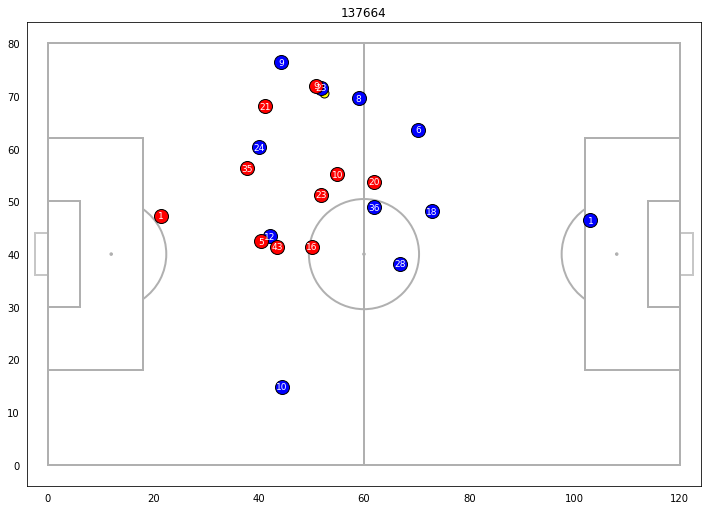

time: 3min 3s


In [54]:
flag_0 = flag_1 = True
t0_x = t0_y = t1_x = t1_y = pd.Series(dtype=float)
def animate_shot(starting_frame, ending_frame, SOU_team):
    ##### Animate the Section to Understand 
    from matplotlib import animation
    from mplsoccer.pitch import Pitch
    import matplotlib.pyplot as plt

    # Set up formatting for the movie files
    import matplotlib.animation as animation
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1
    
    frames_to_animate = list(range(starting_frame, ending_frame))

    pitch = Pitch(pitch_type='statsbomb',orientation='horizontal',view='full',layout=(1,1), figsize=(10.8, 7.2),
                  pitch_width=120,pitch_length=80,stripe=False,goal_type='box', axis=True, label=True)
    fig, ax = pitch.draw()

    ball, = ax.plot([], [], 'ko', ms=9,markerfacecolor='yellow')
    team_0, = ax.plot([], [], 'ko', ms=14,markerfacecolor='blue',alpha=1) 
    team_1, = ax.plot([], [], 'ko', ms=14,markerfacecolor='red',alpha=1)
    
    # initialization function: plot the background of each frame
    def init():
        ball.set_data([], [])
        team_0.set_data([], [])
        team_1.set_data([], [])
        return ball, team_0, team_1
    
    annotations = []
    # arrows = []
    
    # animation function of dataframes' list

    
    def animate(i):
        ax.set_title(str(frames_to_animate[i]))
        global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1

        frame_ = tracking[tracking['frameIdx'] == frames_to_animate[i]]
        ball_ = frame_[frame_['Team_Name'] == 'BALL'].reset_index()
        # ball_ = frame_[frame_['playerId'] == 'BALL'].reset_index()
        
        team0_ = frame_[(frame_['Team_Name'] != 'SOU ') & (frame_['Team_Name'] != 'BALL')].reset_index()
        number0_ = frame_[(frame_['Team_Name'] != 'SOU ') & (frame_['Team_Name'] != 'BALL')].reset_index()[['number']]
        
        team1_ = frame_[frame_['Team_Name'] == 'SOU '].reset_index()
        number1_ = frame_[frame_['Team_Name'] == 'SOU '].reset_index()[['number']]
        
        number0_.number = number0_.number.apply(lambda x: int(x))
        number1_.number = number1_.number.apply(lambda x: int(x))
        
        # set the ball data with the x and y positions for the ith frame
        ball.set_data(ball_.ball_x1, ball_.ball_y1)
        
        # set the player data using the frame id
        team_0.set_data(team0_.x1,team0_.y1)
        team_1.set_data(team1_.x1,team1_.y1)
        
        for i, a in enumerate(annotations):
            a.remove()
        annotations[:] = []
#         for i, a in enumerate(arrows):
#             a.remove()
        
#         arrows[:] = []
        
        # update for team 0
        for k in range(len(team0_)):
            try:
                annot1 = pitch.annotate(number0_.number[k], (team0_.x1[k], team0_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot1)

#                 arr1 = pitch.arrows(team0_.x1[k], team0_.y1[k],
#                                     t0_x[k] + team0_.speed[k], t0_y[k] - team0_.speed[k],                                    
#                                     width=2, headwidth=10, headlength=10, color='#ad993c', ax=ax)
#                 arrows.append(arr1)                
            except Exception as ex:
                pass
            t0_x = team0_.x1
            t0_y = team0_.y1
        
        # update for team 1
        for k in range(len(team1_)):
            try:
                annot2 = pitch.annotate(number1_.number[k], (team1_.x1[k], team1_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot2)
#                 arr2 = pitch.arrows(team1_.x1[k], team1_.y1[k],
#                                     t1_x[k] + team1_.speed[k], t1_y[k] - team1_.speed[k],                                    
#                                     width=2, headwidth=5, headlength=5, color='#ad993c', ax=ax)                    

#                 arrows.append(arr2)                
            except Exception as ex:
                pass
            t1_x = team1_.x1
            t1_y = team1_.y1
        
               
        
        ax.set_xlim(-4,124)
        ax.set_ylim(-4,84)
        #ax.axvline(x=40,alpha=0.1,color="beige")
        #ax.axvline(x=80,alpha=0.1,color="beige")
        #ax.axhline(y=12,alpha=0.1,color="beige")
        #ax.axhline(y=26,alpha=0.1,color="beige")
        #ax.axhline(y=54,alpha=0.1,color="beige")
        #ax.axhline(y=68,alpha=0.1,color="beige")
        
        
        return ball, team_0, team_1
    
    # call the animator, animate every 300 ms
    # note that its hard to get the ffmpeg requirements right. I installed from conda-forge: see the conda.yml file
    anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_animate), init_func=init, interval=25, blit=True)
    return(anim)

end=137665
start=137465
anim = animate_shot(start,end, 1).to_html5_video()
HTML(anim)




In [110]:
mask = (tracking1['frameIdx'] >= 133161) & (tracking1['frameIdx'] <= 133227)
df1 = tracking1.loc[mask]
df1.to_csv(r"C:\Users\Home\Documents\check4.csv")

time: 117 ms


In [ ]:
#df1.distance_to_ball.value_counts.hist()
df1.distance_to_ball.value_counts().plot(kind='barh', figsize=(8, 6))

In [ ]:
tracking.Team_Name.unique()

In [ ]:
df1.reset_index(drop=True)
ball_check=df1[df1['Team_Name']=='BALL']
x=ball_check['x1']
ax = x.plot.hist(bins=12, alpha=0.5)

In [ ]:
tracking['Dead_live_count'] = tracking.groupby((tracking['Live'] != tracking['Live'].shift(1)).cumsum()).cumcount()+1

subset=tracking[tracking['Dead_live_count'] ==1]
subset=subset[['gameClock',"Live"]].reset_index(drop=True)
subset=subset[subset['Live'] =='Dead']

In [ ]:
subset

In [ ]:
tracking.gameClock1=tracking.gameClock/60
tracking.loc[tracking['period'] == 2, 'gameClock1'] = tracking['gameClock1']+45

In [ ]:
tracking.gameClock1.unique()

In [ ]:
tracking.gameClock=round(tracking.gameClock, 2)
tracking.gameClock.unique()

In [ ]:
tracking.tail(23)

In [ ]:
mask = (tracking['gameClock1'] > 78.00) & (tracking['gameClock1'] <= 79.00)
df1 = tracking.loc[mask]
df1

In [ ]:
mask = (tracking['gameClock1'] > 85.00) & (tracking['gameClock1'] <= 86.00)
df1 = tracking.loc[mask]

In [ ]:
print(max(df1.frameIdx))
print(min(df1.frameIdx))

In [ ]:
flag_0 = flag_1 = True
t0_x = t0_y = t1_x = t1_y = pd.Series(dtype=float)
def animate_shot(starting_frame, ending_frame, SOU_team):
    ##### Animate the Section to Understand 
    from matplotlib import animation
    from mplsoccer.pitch import Pitch
    import matplotlib.pyplot as plt

    # Set up formatting for the movie files
    import matplotlib.animation as animation
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1
    
    frames_to_animate = list(range(starting_frame, ending_frame))

    pitch = Pitch(pitch_type='statsbomb',orientation='horizontal',view='full',layout=(1,1), figsize=(10.8, 7.2),
                  pitch_width=105,pitch_length=68,stripe=False,goal_type='box', axis=True, label=True)
    fig, ax = pitch.draw()

    ball, = ax.plot([], [], 'ko', ms=9,markerfacecolor='yellow')
    team_0, = ax.plot([], [], 'ko', ms=14,markerfacecolor='blue',alpha=1) 
    team_1, = ax.plot([], [], 'ko', ms=14,markerfacecolor='red',alpha=1)
    
    # initialization function: plot the background of each frame
    def init():
        ball.set_data([], [])
        team_0.set_data([], [])
        team_1.set_data([], [])
        return ball, team_0, team_1
    
    annotations = []
    # arrows = []
    
    # animation function of dataframes' list

    
    def animate(i):
        ax.set_title(str(frames_to_animate[i]))
        global t0_x, t0_y, t1_x, t1_y, flag_0, flag_1

        frame_ = tracking[tracking['frameIdx'] == frames_to_animate[i]]
        ball_ = frame_[frame_['Team_Name'] == 'BALL'].reset_index()
        # ball_ = frame_[frame_['playerId'] == 'BALL'].reset_index()
        
        team0_ = frame_[(frame_['Team_Name'] != 'SOU ') & (frame_['Team_Name'] != 'BALL')].reset_index()
        number0_ = frame_[(frame_['Team_Name'] != 'SOU ') & (frame_['Team_Name'] != 'BALL')].reset_index()[['number']]
        
        team1_ = frame_[frame_['Team_Name'] == 'SOU '].reset_index()
        number1_ = frame_[frame_['Team_Name'] == 'SOU '].reset_index()[['number']]
        
        number0_.number = number0_.number.apply(lambda x: int(x))
        number1_.number = number1_.number.apply(lambda x: int(x))
        
        # set the ball data with the x and y positions for the ith frame
        ball.set_data(ball_.ball_x1, ball_.ball_y1)
        
        # set the player data using the frame id
        team_0.set_data(team0_.x1,team0_.y1)
        team_1.set_data(team1_.x1,team1_.y1)
        
        for i, a in enumerate(annotations):
            a.remove()
        annotations[:] = []
#         for i, a in enumerate(arrows):
#             a.remove()
        
#         arrows[:] = []
        
        # update for team 0
        for k in range(len(team0_)):
            try:
                annot1 = pitch.annotate(number0_.number[k], (team0_.x1[k], team0_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot1)

#                 arr1 = pitch.arrows(team0_.x1[k], team0_.y1[k],
#                                     t0_x[k] + team0_.speed[k], t0_y[k] - team0_.speed[k],                                    
#                                     width=2, headwidth=10, headlength=10, color='#ad993c', ax=ax)
#                 arrows.append(arr1)                
            except Exception as ex:
                pass
            t0_x = team0_.x1
            t0_y = team0_.y1
        
        # update for team 1
        for k in range(len(team1_)):
            try:
                annot2 = pitch.annotate(number1_.number[k], (team1_.x1[k], team1_.y1[k]), va='center',
                              ha='center', color='white', fontsize=9, ax=ax)
                annotations.append(annot2)
#                 arr2 = pitch.arrows(team1_.x1[k], team1_.y1[k],
#                                     t1_x[k] + team1_.speed[k], t1_y[k] - team1_.speed[k],                                    
#                                     width=2, headwidth=5, headlength=5, color='#ad993c', ax=ax)                    

#                 arrows.append(arr2)                
            except Exception as ex:
                pass
            t1_x = team1_.x1
            t1_y = team1_.y1
        
               
        
        ax.set_xlim(-4,124)
        ax.set_ylim(-4,84)
        #ax.axvline(x=40,alpha=0.1,color="beige")
        #ax.axvline(x=80,alpha=0.1,color="beige")
        #ax.axhline(y=12,alpha=0.1,color="beige")
        #ax.axhline(y=26,alpha=0.1,color="beige")
        #ax.axhline(y=54,alpha=0.1,color="beige")
        #ax.axhline(y=68,alpha=0.1,color="beige")
        
        
        return ball, team_0, team_1
    
    # call the animator, animate every 300 ms
    # note that its hard to get the ffmpeg requirements right. I installed from conda-forge: see the conda.yml file
    anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_animate), init_func=init, interval=25, blit=True)
    return(anim)

anim = animate_shot(15775,15874, 1).to_html5_video()
HTML(anim)

In [ ]:
#Checking the first ranks: CLosest to the ball 
rank_first=tracking[tracking['rank']==2]
first=rank_first[(rank_first['distance_to_ball']<3)& (rank_first['distance_to_ball']>2.5)]

##Add the frameId's to a list
all_out_possession_frames=first.frameIdx.to_list()

#Checking the histogram to see who the closest to the ball are
first['distance_to_ball'].hist()


In [ ]:
#Plot the frames
from matplotlib.figure import Figure
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from pitch2 import Pitch
from matplotlib import style
from scipy.spatial import ConvexHull

import random
import warnings
warnings.filterwarnings(action='once')

samples = random.sample(sample, 25)

for frame_select in samples:
    
    #frame_select = 1590

    track_seg = tracking[tracking.frameIdx == frame_select].reset_index(drop=True)

    team_1_seg = track_seg[(track_seg['Team_Name'] == 'SOU ')].reset_index()
    team_0_seg = track_seg[(track_seg['Team_Name'] == ' NEW ')].reset_index()
    ball_seg = track_seg[track_seg['Team_Name'] == 'BALL'].reset_index()

    pitch = Pitch(pitch_type='statsbomb',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
                  pitch_width=68,pitch_length=105,stripe=True,goal_type='line',axis=False,label=True)
    fig, ax = pitch.draw()

    ball, = ax.plot(ball_seg.x1, ball_seg.y1, 'ko', ms=12,markerfacecolor='yellow',zorder=10)
    team_0, = ax.plot(team_0_seg.x1, team_0_seg.y1, 'ko', ms=20,markerfacecolor='blue') #red/maroon
    team_1, = ax.plot(team_1_seg.x1, team_1_seg.y1, 'ko', ms=20,markerfacecolor='red') #purple


    #team_0, = ax.plot(team_1_seg.x1.mean(), team_1_seg.y1.mean(), 'ko', ms=10,markerfacecolor='green') #red/maroon
    plt.title(str(track_seg['ball_handler'][0]))
    plt.show()


In [ ]:
#samples
check=tracking[tracking.isin(samples)]

In [ ]:
overload_calcs.to_csv(r'C:\Users\Home\Documents\overload_calcs.csv')

In [ ]:
NO_BALL_tracking = tracking[tracking['playerId'] != '00000']
BALL_tracking = tracking[tracking['playerId'] == '00000']

NO_BALL_tracking=NO_BALL_tracking.sort_values(['frameIdx','distance_to_ball'], ascending=[True,True])
#NO_BALL_tracking=NO_BALL_tracking[['frameIdx','playerId','name','distance_to_ball','Team_Name','position','x1']]
NO_BALL_tracking["rank"] = NO_BALL_tracking.groupby("frameIdx")["distance_to_ball"].rank("dense", ascending=True)
#Subsetting data for the closest player in every frame (Ball Handler)
Closest_to_ball=NO_BALL_tracking[NO_BALL_tracking["rank"]==1.0].rename(columns={'Team_Name':'Team_Possession','name':'ball_handler'})
Closest_to_ball=Closest_to_ball[['frameIdx','ball_handler','distance_to_ball','Team_Possession','position','x1']]

